# A test of our custom xgboost pipeline with feature explanation

In [1]:
# Import modules

import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
from matplotlib import markers
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, auc, classification_report, f1_score, log_loss, precision_recall_curve, roc_curve, roc_auc_score, precision_score, recall_score, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.feature_selection import mutual_info_classif, SelectFromModel, SelectKBest
from sklearn.isotonic import IsotonicRegression
from sklearn.preprocessing import LabelBinarizer
from xgboost.sklearn import XGBClassifier
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from random import uniform
from bayes_opt import BayesianOptimization
import lime
import shap

In [2]:
# Set plot style
plt.style.use('dark_background')

In [3]:
# Set pandas preferences:
pd.options.display.max_columns=500
pd.options.display.max_colwidth=1000

In [4]:
# Make some test data
from sklearn.datasets import make_classification

In [5]:
data, target = make_classification(n_samples=10000,
                                   n_features=50,
                                   n_informative=30,
                                   n_redundant=10)

In [6]:
# Split up the data as needed.
train_X, calibrate_X, train_y, calibrate_y = train_test_split(data, target, test_size=0.1)

In [7]:
train_X, test_X, train_y, test_y = train_test_split(train_X, train_y, test_size=0.2)

# Some useful functions

In [8]:
def make_roc_curves_array(true_vals, scores_vals, figsize=(10,10)):
    """Function for making nice-ish looking roc curves."""
    fpr, tpr, threshold = roc_curve(y_true=true_vals, y_score=scores_vals)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=figsize)
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc='lower right')
    plt.show()
    
    return fpr, tpr, threshold, roc_auc

In [9]:
def make_roc_curves_df(df, true_col, scores_col, figsize=(10,10)):
    """Function for making nice-ish looking roc curves."""
    fpr, tpr, threshold = roc_curve(y_true=df[true_col].values, y_score=df[scores_col].values)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=figsize)
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc='lower right')
    plt.show()
    
    return fpr, tpr, threshold, roc_auc

In [10]:
def calibration_func_array(true_vals, probability_vals_list, legend_labels, title, n_bins=20, figsize=(10,10)):
    """Function for making reliability plots"""
    y_vals = []
    x_vals = []
    for vals in probability_vals_list:
        y_array, x_array = calibration_curve(true_vals, vals, n_bins=n_bins)
        y_vals.append(y_array)
        x_vals.append(x_array)
    
    fig, ax = plt.subplots(figsize=figsize)
    for i in range(0, len(legend_labels)):
        plt.plot(x_vals[i], y_vals[i], linewidth=1, label=legend_labels[i], marker=markers.MarkerStyle.filled_markers[i])
    
    # Reference line, legends, and axis labels
    line = mlines.line2D([0, 1], [0, 1], color='white')
    transform = ax.transAxes
    line.set_transform(transform)
    ax.add_line(line)
    fig.suptitle(title)
    ax.set_xlabel('Predicted probability')
    ax.set_ylabel('True probability in each bin')
    plt.legend()
    plt.show()

In [13]:
def make_score_distribution(df, proba_cols, true_col, true_label, title=None, figsize=(10,10)):
    fig, ax = plt.subplots(figsize=figsize)
    sns.distplot(df[proba_cols[0]].loc[(df[true_col] == true_label)], kde=False, ax=ax)
    if title:
        sns.distplot(df[proba_cols[1]].loc[(df[true_col] == true_label)], kde=False, ax=ax).set_title(title)
    else:
        sns.distplot(df[proba_cols[1]].loc[(df[true_col] == true_label)], kde=False, ax=ax)
    ax.set(xlabel='score', ylabel='count')
    plt.show()

# Custom xgboost classifier class object

In [72]:
class EarlyStoppingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifier, evaluation_metric, num_rounds, feature_selector=None, validation_size=None):
        self.classifier = classifier
        self.evaluation_metric = evaluation_metric
        self.num_rounds = num_rounds
        self.feature_selector = feature_selector
        self.validation_size = validation_size
        self.classes_ = None
        self.classifier_ = None
        self.feature_selector_ = None
        
    def fit(self, X, y):
        """Function for fitting the base estimator.  Implements feature selection and also auto generates a validation set for early stopping.
        Also supports probability calibration."""
        labelbin = LabelBinarizer()
        Y = labelbin.fit_transform(y)
        self.classes_ = labelbin.classes_
        
        # Do feature selection if desired
        if self.feature_selector:
            X_use = self.feature_select(X, y)
        else:
            X_use = X
        
        # Make the validation set:
        X_train, X_valid, y_train, y_valid = self.make_validation_set(X_use, y)

        # Fit the base estimator
        self.classifier_ = clone(self.classifier)
        self.classifier = self.classifier_.fit(X_train,
                                               y_train,
                                               eval_metric=self.evaluation_metric,
                                               eval_set=[[X_valid, y_valid]],
                                               early_stopping_rounds=self.num_rounds)
        
        return self
    
    def predict(self, X):
        """Makes predictions on input data from trained classifier.  
        If feature selection is used, it is applied automatically to the input data."""
        # The predict function changes in XGBoost when early stopping is performed.
        if self.feature_selector:
            X_select = self.feature_selector.transform(X)
        else:
            X_select = X
            
        # This method should only be called once the model is fit anyway, and since we are always using early stopping, 
        # we can set ntree_limit by default.
        return self.classifier.predict(X_select, ntree_limit=self.classifier.best_ntree_limit)
    
    def predict_proba(self, X):
        """Makes probability predictions on input data from trained classifier.  If feature selection is used,
        it is applied automatically to the input data.  Since this method should only be called after the 
        classifier is fit, and since we are always using early stopping, the best_ntree_limit should be defined by default."""
        if self.feature_selector:
            X_select = self.feature_selector.transform(X)
        else:
            X_select = X
        
        return self.classifier.predict_proba(X_select, ntree_limit=self.classifier.best_ntree_limit)

    def feature_select(self, X, y):
        """Implements feature selection if so desired."""
        # TODO: Get tree based feature selection working.
        self.feature_selector_ = clone(self.feature_selector)
        self.feature_selector = self.feature_selector_.fit(X, y)
        
        return self.feature_selector.transform(X)
        
    def make_validation_set(self, X, y):
        """Makes the validation set."""
        if self.validation_size:
            val_size = self.validation_size
        else:
            val_size = 0.1
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=val_size)
        return X_train, X_valid, y_train, y_valid
    
    def explain_shap(self, df_X):
        if self.feature_selector:
            df_transformed = df_X[df_X.columns[self.feature_selector.get_support(indices=True)]]
        else:
            df_transformed = df_X
        
        # Build the explainer
        explainer = shap.TreeExplainer(self.classifier)
        
        return explainer, df_transformed
        

In [73]:
# Define the number of cross validation folds to use.
cv = 5

In [74]:
# Define the alpha parameter for the gaussian process used in bayesian hyperparameter optimization.  We should try using different kernels.  They all make different 
# assumptions about the loss function, so it isn't clear that this is the best choice.
gp_params = {'alpha': 1e-5}

In [75]:
def custom_xgboost_for_opt(feature_selector__k, classifier__max_depth, classifier__min_child_weight, classifier__learning_rate, classifier__n_estimators, classifier__colsample_bytree, classifier__subsample, classifier__seed):
    params_bayes = {}
    params_bayes['feature_selector__k'] = int(feature_selector__k)
    params_bayes['classifier__max_depth'] = int(classifier__max_depth)
    params_bayes['classifier__min_child_weight'] = int(classifier__min_child_weight)
    params_bayes['classifier__learning_rate'] = max(classifier__learning_rate, 0)
    params_bayes['classifier__n_estimators'] = int(classifier__n_estimators)
    params_bayes['classifier__colsample_bytree'] = max(min(classifier__colsample_bytree, 1), 0)
    params_bayes['classifier__subsample'] = max(min(classifier__subsample, 1), 0)
    params_bayes['classifier__seed'] = int(classifier__seed)
    
    to_optimize = EarlyStoppingClassifier(classifier=XGBClassifier(objective='binary:logistic', booster='gbtree', slient=True),
                                          feature_selector=SelectKBest(score_func=mutual_info_classif),
                                          evaluation_metric='logloss',
                                          num_rounds=5)
    to_optimize.set_params(**params_bayes)
    # This is annoying.  The data and params dictionary is assumed to be global.  Weird way to do this...
    # We'll use recall as the scoring function to keep it even with the random search approach
    val = cross_val_score(to_optimize, X=train_X, y=train_y, scoring='recall', cv=5).mean()
    
    return val

In [76]:
# This defines the bounds on the hyperparameters to search.  Should I just input the unchanging values by hand?
param_bounds = {'feature_selector__k': (20, 45),
              'classifier__max_depth': (3, 15),
              'classifier__min_child_weight': (1, 5),
              'classifier__learning_rate': (0.01, 0.2),
              'classifier__n_estimators': (1000, 1000),
              'classifier__colsample_bytree': (0.7, 1),
              'classifier__subsample': (0.7, 1),
              'classifier__seed': (0, 0)}

In [77]:
xgboost_custom_BO = BayesianOptimization(custom_xgboost_for_opt, param_bounds)

In [78]:
xgboost_custom_BO.maximize(n_iter=10, **gp_params)

Initialization
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   classifier__colsample_bytree |   classifier__learning_rate |   classifier__max_depth |   classifier__min_child_weight |   classifier__n_estimators |   classifier__seed |   classifier__subsample |   feature_selector__k | 
[0]	validation_0-logloss:0.628759
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.577078
[2]	validation_0-logloss:0.535363
[3]	validation_0-logloss:0.493045
[4]	validation_0-logloss:0.454035
[5]	validation_0-logloss:0.423884
[6]	validation_0-logloss:0.39753
[7]	validation_0-logloss:0.378046
[8]	validation_0-logloss:0.359448
[9]	validation_0-logloss:0.341034
[10]	validation_0-logloss:0.326146
[11]	validation_0-logloss:0.312454
[12]

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.625751
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.568089
[2]	validation_0-logloss:0.522612
[3]	validation_0-logloss:0.493054
[4]	validation_0-logloss:0.467025
[5]	validation_0-logloss:0.445223
[6]	validation_0-logloss:0.421513
[7]	validation_0-logloss:0.399304
[8]	validation_0-logloss:0.378775
[9]	validation_0-logloss:0.362047
[10]	validation_0-logloss:0.344803
[11]	validation_0-logloss:0.330129
[12]	validation_0-logloss:0.31721
[13]	validation_0-logloss:0.307183
[14]	validation_0-logloss:0.297653
[15]	validation_0-logloss:0.289705
[16]	validation_0-logloss:0.28471
[17]	validation_0-logloss:0.275233
[18]	validation_0-logloss:0.270425
[19]	validation_0-logloss:0.26559
[20]	validation_0-logloss:0.260436
[21]	validation_0-logloss:0.255663
[22]	validation_0-logloss:0.250075
[23]	validation_0-logloss:0.243963
[24]	validation_0-logloss:0.237783
[25]	validation_0-logloss:0.232908
[26]	validation_0-logloss:0.226494
[

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.620281
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.561506
[2]	validation_0-logloss:0.516852
[3]	validation_0-logloss:0.479937
[4]	validation_0-logloss:0.450219
[5]	validation_0-logloss:0.418223
[6]	validation_0-logloss:0.396399
[7]	validation_0-logloss:0.375209
[8]	validation_0-logloss:0.354122
[9]	validation_0-logloss:0.338772
[10]	validation_0-logloss:0.324838
[11]	validation_0-logloss:0.310601
[12]	validation_0-logloss:0.300192
[13]	validation_0-logloss:0.292459
[14]	validation_0-logloss:0.284146
[15]	validation_0-logloss:0.278717
[16]	validation_0-logloss:0.271325
[17]	validation_0-logloss:0.265045
[18]	validation_0-logloss:0.259937
[19]	validation_0-logloss:0.253945
[20]	validation_0-logloss:0.248765
[21]	validation_0-logloss:0.244491
[22]	validation_0-logloss:0.240367
[23]	validation_0-logloss:0.237673
[24]	validation_0-logloss:0.23214
[25]	validation_0-logloss:0.230395
[26]	validation_0-logloss:0.228004

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.636191
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.583488
[2]	validation_0-logloss:0.533653
[3]	validation_0-logloss:0.496747
[4]	validation_0-logloss:0.461079
[5]	validation_0-logloss:0.433763
[6]	validation_0-logloss:0.41238
[7]	validation_0-logloss:0.387658
[8]	validation_0-logloss:0.371524
[9]	validation_0-logloss:0.361182
[10]	validation_0-logloss:0.349303
[11]	validation_0-logloss:0.335299
[12]	validation_0-logloss:0.324834
[13]	validation_0-logloss:0.314326
[14]	validation_0-logloss:0.304856
[15]	validation_0-logloss:0.296746
[16]	validation_0-logloss:0.288782
[17]	validation_0-logloss:0.282844
[18]	validation_0-logloss:0.277675
[19]	validation_0-logloss:0.272181
[20]	validation_0-logloss:0.268828
[21]	validation_0-logloss:0.263347
[22]	validation_0-logloss:0.257911
[23]	validation_0-logloss:0.252595
[24]	validation_0-logloss:0.248912
[25]	validation_0-logloss:0.243154
[26]	validation_0-logloss:0.238527

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.622585
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.567083
[2]	validation_0-logloss:0.52718
[3]	validation_0-logloss:0.491959
[4]	validation_0-logloss:0.462397
[5]	validation_0-logloss:0.435941
[6]	validation_0-logloss:0.410029
[7]	validation_0-logloss:0.388691
[8]	validation_0-logloss:0.368662
[9]	validation_0-logloss:0.350397
[10]	validation_0-logloss:0.337723
[11]	validation_0-logloss:0.325285
[12]	validation_0-logloss:0.310787
[13]	validation_0-logloss:0.299145
[14]	validation_0-logloss:0.286847
[15]	validation_0-logloss:0.280298
[16]	validation_0-logloss:0.272034
[17]	validation_0-logloss:0.266267
[18]	validation_0-logloss:0.2597
[19]	validation_0-logloss:0.25611
[20]	validation_0-logloss:0.250265
[21]	validation_0-logloss:0.244344
[22]	validation_0-logloss:0.24007
[23]	validation_0-logloss:0.237772
[24]	validation_0-logloss:0.23187
[25]	validation_0-logloss:0.227561
[26]	validation_0-logloss:0.22247
[27]	

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.608162
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.543153
[2]	validation_0-logloss:0.49134
[3]	validation_0-logloss:0.448836
[4]	validation_0-logloss:0.410091
[5]	validation_0-logloss:0.383862
[6]	validation_0-logloss:0.363156
[7]	validation_0-logloss:0.343852
[8]	validation_0-logloss:0.325755
[9]	validation_0-logloss:0.307682
[10]	validation_0-logloss:0.294483
[11]	validation_0-logloss:0.282352
[12]	validation_0-logloss:0.275736
[13]	validation_0-logloss:0.267621
[14]	validation_0-logloss:0.256604
[15]	validation_0-logloss:0.2459
[16]	validation_0-logloss:0.239862
[17]	validation_0-logloss:0.235278
[18]	validation_0-logloss:0.228313
[19]	validation_0-logloss:0.226016
[20]	validation_0-logloss:0.223709
[21]	validation_0-logloss:0.219522
[22]	validation_0-logloss:0.216267
[23]	validation_0-logloss:0.211811
[24]	validation_0-logloss:0.207831
[25]	validation_0-logloss:0.203266
[26]	validation_0-logloss:0.202004
[

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.609393
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.546964
[2]	validation_0-logloss:0.495013
[3]	validation_0-logloss:0.457289
[4]	validation_0-logloss:0.427049
[5]	validation_0-logloss:0.39657
[6]	validation_0-logloss:0.373578
[7]	validation_0-logloss:0.353072
[8]	validation_0-logloss:0.336856
[9]	validation_0-logloss:0.319462
[10]	validation_0-logloss:0.306376
[11]	validation_0-logloss:0.291788
[12]	validation_0-logloss:0.28192
[13]	validation_0-logloss:0.27253
[14]	validation_0-logloss:0.26106
[15]	validation_0-logloss:0.250541
[16]	validation_0-logloss:0.242776
[17]	validation_0-logloss:0.235866
[18]	validation_0-logloss:0.230166
[19]	validation_0-logloss:0.224544
[20]	validation_0-logloss:0.218539
[21]	validation_0-logloss:0.212092
[22]	validation_0-logloss:0.207011
[23]	validation_0-logloss:0.204363
[24]	validation_0-logloss:0.19996
[25]	validation_0-logloss:0.196497
[26]	validation_0-logloss:0.19479
[27]

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.615788
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.55351
[2]	validation_0-logloss:0.50553
[3]	validation_0-logloss:0.463398
[4]	validation_0-logloss:0.429392
[5]	validation_0-logloss:0.40537
[6]	validation_0-logloss:0.381143
[7]	validation_0-logloss:0.361694
[8]	validation_0-logloss:0.349161
[9]	validation_0-logloss:0.331852
[10]	validation_0-logloss:0.317111
[11]	validation_0-logloss:0.307392
[12]	validation_0-logloss:0.29664
[13]	validation_0-logloss:0.28884
[14]	validation_0-logloss:0.282537
[15]	validation_0-logloss:0.271788
[16]	validation_0-logloss:0.265243
[17]	validation_0-logloss:0.263028
[18]	validation_0-logloss:0.257162
[19]	validation_0-logloss:0.252372
[20]	validation_0-logloss:0.248448
[21]	validation_0-logloss:0.243336
[22]	validation_0-logloss:0.238278
[23]	validation_0-logloss:0.233778
[24]	validation_0-logloss:0.230917
[25]	validation_0-logloss:0.227239
[26]	validation_0-logloss:0.223328
[27

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.608578
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.546983
[2]	validation_0-logloss:0.494994
[3]	validation_0-logloss:0.451838
[4]	validation_0-logloss:0.415826
[5]	validation_0-logloss:0.389224
[6]	validation_0-logloss:0.36447
[7]	validation_0-logloss:0.343707
[8]	validation_0-logloss:0.326932
[9]	validation_0-logloss:0.311118
[10]	validation_0-logloss:0.297977
[11]	validation_0-logloss:0.284194
[12]	validation_0-logloss:0.271745
[13]	validation_0-logloss:0.263756
[14]	validation_0-logloss:0.257767
[15]	validation_0-logloss:0.25017
[16]	validation_0-logloss:0.244643
[17]	validation_0-logloss:0.2394
[18]	validation_0-logloss:0.235626
[19]	validation_0-logloss:0.228502
[20]	validation_0-logloss:0.222702
[21]	validation_0-logloss:0.217967
[22]	validation_0-logloss:0.213768
[23]	validation_0-logloss:0.210542
[24]	validation_0-logloss:0.205836
[25]	validation_0-logloss:0.20019
[26]	validation_0-logloss:0.19799
[27]

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.610212
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.541323
[2]	validation_0-logloss:0.485566
[3]	validation_0-logloss:0.443684
[4]	validation_0-logloss:0.405786
[5]	validation_0-logloss:0.379818
[6]	validation_0-logloss:0.359403
[7]	validation_0-logloss:0.340093
[8]	validation_0-logloss:0.323642
[9]	validation_0-logloss:0.305376
[10]	validation_0-logloss:0.289158
[11]	validation_0-logloss:0.276443
[12]	validation_0-logloss:0.267058
[13]	validation_0-logloss:0.257555
[14]	validation_0-logloss:0.246913
[15]	validation_0-logloss:0.240774
[16]	validation_0-logloss:0.231346
[17]	validation_0-logloss:0.224262
[18]	validation_0-logloss:0.217563
[19]	validation_0-logloss:0.212137
[20]	validation_0-logloss:0.204479
[21]	validation_0-logloss:0.197745
[22]	validation_0-logloss:0.19202
[23]	validation_0-logloss:0.187293
[24]	validation_0-logloss:0.184059
[25]	validation_0-logloss:0.18011
[26]	validation_0-logloss:0.176284


/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.674376
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.657301
[2]	validation_0-logloss:0.638911
[3]	validation_0-logloss:0.623689
[4]	validation_0-logloss:0.608278
[5]	validation_0-logloss:0.595071
[6]	validation_0-logloss:0.581088
[7]	validation_0-logloss:0.570066
[8]	validation_0-logloss:0.558119
[9]	validation_0-logloss:0.545282
[10]	validation_0-logloss:0.534333
[11]	validation_0-logloss:0.523486
[12]	validation_0-logloss:0.513579
[13]	validation_0-logloss:0.503638
[14]	validation_0-logloss:0.494723
[15]	validation_0-logloss:0.48629
[16]	validation_0-logloss:0.478149
[17]	validation_0-logloss:0.471245
[18]	validation_0-logloss:0.462028
[19]	validation_0-logloss:0.455315
[20]	validation_0-logloss:0.447221
[21]	validation_0-logloss:0.440306
[22]	validation_0-logloss:0.433426
[23]	validation_0-logloss:0.427237
[24]	validation_0-logloss:0.420349
[25]	validation_0-logloss:0.41437
[26]	validation_0-logloss:0.408405


/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.674419
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.65595
[2]	validation_0-logloss:0.640302
[3]	validation_0-logloss:0.624425
[4]	validation_0-logloss:0.609138
[5]	validation_0-logloss:0.594834
[6]	validation_0-logloss:0.580809
[7]	validation_0-logloss:0.567652
[8]	validation_0-logloss:0.555839
[9]	validation_0-logloss:0.543541
[10]	validation_0-logloss:0.533104
[11]	validation_0-logloss:0.522743
[12]	validation_0-logloss:0.513065
[13]	validation_0-logloss:0.502343
[14]	validation_0-logloss:0.492972
[15]	validation_0-logloss:0.485225
[16]	validation_0-logloss:0.476742
[17]	validation_0-logloss:0.46859
[18]	validation_0-logloss:0.462128
[19]	validation_0-logloss:0.455611
[20]	validation_0-logloss:0.449237
[21]	validation_0-logloss:0.442508
[22]	validation_0-logloss:0.435195
[23]	validation_0-logloss:0.42963
[24]	validation_0-logloss:0.423717
[25]	validation_0-logloss:0.418227
[26]	validation_0-logloss:0.412817
[

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.671446
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.652947
[2]	validation_0-logloss:0.635585
[3]	validation_0-logloss:0.620603
[4]	validation_0-logloss:0.605424
[5]	validation_0-logloss:0.590043
[6]	validation_0-logloss:0.576223
[7]	validation_0-logloss:0.56285
[8]	validation_0-logloss:0.550041
[9]	validation_0-logloss:0.537776
[10]	validation_0-logloss:0.526707
[11]	validation_0-logloss:0.516215
[12]	validation_0-logloss:0.505296
[13]	validation_0-logloss:0.495609
[14]	validation_0-logloss:0.486785
[15]	validation_0-logloss:0.477523
[16]	validation_0-logloss:0.468121
[17]	validation_0-logloss:0.461947
[18]	validation_0-logloss:0.452935
[19]	validation_0-logloss:0.445503
[20]	validation_0-logloss:0.439132
[21]	validation_0-logloss:0.433003
[22]	validation_0-logloss:0.426557
[23]	validation_0-logloss:0.420936
[24]	validation_0-logloss:0.415621
[25]	validation_0-logloss:0.409638
[26]	validation_0-logloss:0.404839

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.675098
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.657913
[2]	validation_0-logloss:0.639307
[3]	validation_0-logloss:0.622749
[4]	validation_0-logloss:0.608196
[5]	validation_0-logloss:0.592741
[6]	validation_0-logloss:0.57984
[7]	validation_0-logloss:0.567333
[8]	validation_0-logloss:0.553499
[9]	validation_0-logloss:0.540918
[10]	validation_0-logloss:0.530766
[11]	validation_0-logloss:0.519272
[12]	validation_0-logloss:0.509239
[13]	validation_0-logloss:0.498423
[14]	validation_0-logloss:0.488489
[15]	validation_0-logloss:0.480035
[16]	validation_0-logloss:0.472572
[17]	validation_0-logloss:0.464524
[18]	validation_0-logloss:0.457458
[19]	validation_0-logloss:0.45015
[20]	validation_0-logloss:0.443681
[21]	validation_0-logloss:0.436906
[22]	validation_0-logloss:0.430557
[23]	validation_0-logloss:0.425022
[24]	validation_0-logloss:0.418752
[25]	validation_0-logloss:0.412537
[26]	validation_0-logloss:0.406568


/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.675706
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.658542
[2]	validation_0-logloss:0.641359
[3]	validation_0-logloss:0.627368
[4]	validation_0-logloss:0.612413
[5]	validation_0-logloss:0.59851
[6]	validation_0-logloss:0.584928
[7]	validation_0-logloss:0.573035
[8]	validation_0-logloss:0.562661
[9]	validation_0-logloss:0.551529
[10]	validation_0-logloss:0.541057
[11]	validation_0-logloss:0.53091
[12]	validation_0-logloss:0.523048
[13]	validation_0-logloss:0.513634
[14]	validation_0-logloss:0.505368
[15]	validation_0-logloss:0.495782
[16]	validation_0-logloss:0.488028
[17]	validation_0-logloss:0.480561
[18]	validation_0-logloss:0.472791
[19]	validation_0-logloss:0.465403
[20]	validation_0-logloss:0.459011
[21]	validation_0-logloss:0.452764
[22]	validation_0-logloss:0.445975
[23]	validation_0-logloss:0.439674
[24]	validation_0-logloss:0.432969
[25]	validation_0-logloss:0.427
[26]	validation_0-logloss:0.421276
[27

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.655623
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.61952
[2]	validation_0-logloss:0.587259
[3]	validation_0-logloss:0.560916
[4]	validation_0-logloss:0.536676
[5]	validation_0-logloss:0.517235
[6]	validation_0-logloss:0.496745
[7]	validation_0-logloss:0.476359
[8]	validation_0-logloss:0.458397
[9]	validation_0-logloss:0.44456
[10]	validation_0-logloss:0.429448
[11]	validation_0-logloss:0.417597
[12]	validation_0-logloss:0.407117
[13]	validation_0-logloss:0.39531
[14]	validation_0-logloss:0.383938
[15]	validation_0-logloss:0.374066
[16]	validation_0-logloss:0.364962
[17]	validation_0-logloss:0.356235
[18]	validation_0-logloss:0.347206
[19]	validation_0-logloss:0.338344
[20]	validation_0-logloss:0.330896
[21]	validation_0-logloss:0.324732
[22]	validation_0-logloss:0.319904
[23]	validation_0-logloss:0.313865
[24]	validation_0-logloss:0.307705
[25]	validation_0-logloss:0.302408
[26]	validation_0-logloss:0.297802
[

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.656914
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.622325
[2]	validation_0-logloss:0.592409
[3]	validation_0-logloss:0.564276
[4]	validation_0-logloss:0.535881
[5]	validation_0-logloss:0.518191
[6]	validation_0-logloss:0.497766
[7]	validation_0-logloss:0.478334
[8]	validation_0-logloss:0.463027
[9]	validation_0-logloss:0.447834
[10]	validation_0-logloss:0.433077
[11]	validation_0-logloss:0.419935
[12]	validation_0-logloss:0.406239
[13]	validation_0-logloss:0.395421
[14]	validation_0-logloss:0.383663
[15]	validation_0-logloss:0.375785
[16]	validation_0-logloss:0.365941
[17]	validation_0-logloss:0.35875
[18]	validation_0-logloss:0.349247
[19]	validation_0-logloss:0.340829
[20]	validation_0-logloss:0.332816
[21]	validation_0-logloss:0.32616
[22]	validation_0-logloss:0.319427
[23]	validation_0-logloss:0.312877
[24]	validation_0-logloss:0.305429
[25]	validation_0-logloss:0.300924
[26]	validation_0-logloss:0.29663
[

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.651799
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.613772
[2]	validation_0-logloss:0.581991
[3]	validation_0-logloss:0.553306
[4]	validation_0-logloss:0.526311
[5]	validation_0-logloss:0.504118
[6]	validation_0-logloss:0.482967
[7]	validation_0-logloss:0.462333
[8]	validation_0-logloss:0.443225
[9]	validation_0-logloss:0.426701
[10]	validation_0-logloss:0.409585
[11]	validation_0-logloss:0.396213
[12]	validation_0-logloss:0.383203
[13]	validation_0-logloss:0.371433
[14]	validation_0-logloss:0.360362
[15]	validation_0-logloss:0.350634
[16]	validation_0-logloss:0.342848
[17]	validation_0-logloss:0.333987
[18]	validation_0-logloss:0.325634
[19]	validation_0-logloss:0.316302
[20]	validation_0-logloss:0.309916
[21]	validation_0-logloss:0.303069
[22]	validation_0-logloss:0.297253
[23]	validation_0-logloss:0.292453
[24]	validation_0-logloss:0.287248
[25]	validation_0-logloss:0.279936
[26]	validation_0-logloss:0.275
[

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.654903
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.616801
[2]	validation_0-logloss:0.585527
[3]	validation_0-logloss:0.556299
[4]	validation_0-logloss:0.531336
[5]	validation_0-logloss:0.507867
[6]	validation_0-logloss:0.487079
[7]	validation_0-logloss:0.465848
[8]	validation_0-logloss:0.448016
[9]	validation_0-logloss:0.429964
[10]	validation_0-logloss:0.415709
[11]	validation_0-logloss:0.403756
[12]	validation_0-logloss:0.391103
[13]	validation_0-logloss:0.376333
[14]	validation_0-logloss:0.364006
[15]	validation_0-logloss:0.354611
[16]	validation_0-logloss:0.345641
[17]	validation_0-logloss:0.335926
[18]	validation_0-logloss:0.329424
[19]	validation_0-logloss:0.320824
[20]	validation_0-logloss:0.3135
[21]	validation_0-logloss:0.309017
[22]	validation_0-logloss:0.302782
[23]	validation_0-logloss:0.297618
[24]	validation_0-logloss:0.291774
[25]	validation_0-logloss:0.286493
[26]	validation_0-logloss:0.28189
[

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.652288
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.618644
[2]	validation_0-logloss:0.589016
[3]	validation_0-logloss:0.56081
[4]	validation_0-logloss:0.537982
[5]	validation_0-logloss:0.517627
[6]	validation_0-logloss:0.496763
[7]	validation_0-logloss:0.478087
[8]	validation_0-logloss:0.462692
[9]	validation_0-logloss:0.448236
[10]	validation_0-logloss:0.433305
[11]	validation_0-logloss:0.420295
[12]	validation_0-logloss:0.406249
[13]	validation_0-logloss:0.395002
[14]	validation_0-logloss:0.385825
[15]	validation_0-logloss:0.375143
[16]	validation_0-logloss:0.366213
[17]	validation_0-logloss:0.357912
[18]	validation_0-logloss:0.350964
[19]	validation_0-logloss:0.343225
[20]	validation_0-logloss:0.336304
[21]	validation_0-logloss:0.330142
[22]	validation_0-logloss:0.326342
[23]	validation_0-logloss:0.319053
[24]	validation_0-logloss:0.31397
[25]	validation_0-logloss:0.309204
[26]	validation_0-logloss:0.304441


/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.647227
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.611534
[2]	validation_0-logloss:0.569639
[3]	validation_0-logloss:0.537578
[4]	validation_0-logloss:0.508901
[5]	validation_0-logloss:0.484151
[6]	validation_0-logloss:0.461772
[7]	validation_0-logloss:0.442562
[8]	validation_0-logloss:0.42433
[9]	validation_0-logloss:0.409281
[10]	validation_0-logloss:0.398802
[11]	validation_0-logloss:0.385956
[12]	validation_0-logloss:0.377856
[13]	validation_0-logloss:0.371447
[14]	validation_0-logloss:0.362038
[15]	validation_0-logloss:0.355149
[16]	validation_0-logloss:0.348426
[17]	validation_0-logloss:0.340964
[18]	validation_0-logloss:0.336204
[19]	validation_0-logloss:0.330609
[20]	validation_0-logloss:0.324303
[21]	validation_0-logloss:0.317461
[22]	validation_0-logloss:0.313488
[23]	validation_0-logloss:0.310468
[24]	validation_0-logloss:0.304708
[25]	validation_0-logloss:0.301886
[26]	validation_0-logloss:0.297847

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.643947
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.607109
[2]	validation_0-logloss:0.577826
[3]	validation_0-logloss:0.540376
[4]	validation_0-logloss:0.511518
[5]	validation_0-logloss:0.491258
[6]	validation_0-logloss:0.468757
[7]	validation_0-logloss:0.453666
[8]	validation_0-logloss:0.440681
[9]	validation_0-logloss:0.425854
[10]	validation_0-logloss:0.414847
[11]	validation_0-logloss:0.404708
[12]	validation_0-logloss:0.396853
[13]	validation_0-logloss:0.390224
[14]	validation_0-logloss:0.381754
[15]	validation_0-logloss:0.372596
[16]	validation_0-logloss:0.367472
[17]	validation_0-logloss:0.363151
[18]	validation_0-logloss:0.357585
[19]	validation_0-logloss:0.354695
[20]	validation_0-logloss:0.349944
[21]	validation_0-logloss:0.341892
[22]	validation_0-logloss:0.33955
[23]	validation_0-logloss:0.337551
[24]	validation_0-logloss:0.335005
[25]	validation_0-logloss:0.330878
[26]	validation_0-logloss:0.326859

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.640582
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.594856
[2]	validation_0-logloss:0.562142
[3]	validation_0-logloss:0.531413
[4]	validation_0-logloss:0.509937
[5]	validation_0-logloss:0.484175
[6]	validation_0-logloss:0.463237
[7]	validation_0-logloss:0.445012
[8]	validation_0-logloss:0.433601
[9]	validation_0-logloss:0.419826
[10]	validation_0-logloss:0.406088
[11]	validation_0-logloss:0.395588
[12]	validation_0-logloss:0.386832
[13]	validation_0-logloss:0.37732
[14]	validation_0-logloss:0.368967
[15]	validation_0-logloss:0.362215
[16]	validation_0-logloss:0.357991
[17]	validation_0-logloss:0.353022
[18]	validation_0-logloss:0.345764
[19]	validation_0-logloss:0.341047
[20]	validation_0-logloss:0.336358
[21]	validation_0-logloss:0.331412
[22]	validation_0-logloss:0.326073
[23]	validation_0-logloss:0.323549
[24]	validation_0-logloss:0.321051
[25]	validation_0-logloss:0.317852
[26]	validation_0-logloss:0.315086

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.644884
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.609976
[2]	validation_0-logloss:0.5725
[3]	validation_0-logloss:0.54439
[4]	validation_0-logloss:0.523888
[5]	validation_0-logloss:0.503094
[6]	validation_0-logloss:0.482721
[7]	validation_0-logloss:0.46602
[8]	validation_0-logloss:0.451399
[9]	validation_0-logloss:0.439596
[10]	validation_0-logloss:0.428396
[11]	validation_0-logloss:0.418276
[12]	validation_0-logloss:0.409914
[13]	validation_0-logloss:0.400119
[14]	validation_0-logloss:0.392248
[15]	validation_0-logloss:0.38198
[16]	validation_0-logloss:0.375299
[17]	validation_0-logloss:0.369734
[18]	validation_0-logloss:0.363183
[19]	validation_0-logloss:0.358548
[20]	validation_0-logloss:0.352288
[21]	validation_0-logloss:0.349461
[22]	validation_0-logloss:0.345002
[23]	validation_0-logloss:0.340218
[24]	validation_0-logloss:0.337514
[25]	validation_0-logloss:0.334027
[26]	validation_0-logloss:0.328868
[27

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.644174
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.610976
[2]	validation_0-logloss:0.576261
[3]	validation_0-logloss:0.552568
[4]	validation_0-logloss:0.532298
[5]	validation_0-logloss:0.513273
[6]	validation_0-logloss:0.494336
[7]	validation_0-logloss:0.478114
[8]	validation_0-logloss:0.464787
[9]	validation_0-logloss:0.449179
[10]	validation_0-logloss:0.440174
[11]	validation_0-logloss:0.431138
[12]	validation_0-logloss:0.42051
[13]	validation_0-logloss:0.414034
[14]	validation_0-logloss:0.408675
[15]	validation_0-logloss:0.402895
[16]	validation_0-logloss:0.396569
[17]	validation_0-logloss:0.392526
[18]	validation_0-logloss:0.3905
[19]	validation_0-logloss:0.386558
[20]	validation_0-logloss:0.380928
[21]	validation_0-logloss:0.377096
[22]	validation_0-logloss:0.372396
[23]	validation_0-logloss:0.36746
[24]	validation_0-logloss:0.363307
[25]	validation_0-logloss:0.36184
[26]	validation_0-logloss:0.359105
[27

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Bayesian Optimization
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   classifier__colsample_bytree |   classifier__learning_rate |   classifier__max_depth |   classifier__min_child_weight |   classifier__n_estimators |   classifier__seed |   classifier__subsample |   feature_selector__k | 
[0]	validation_0-logloss:0.654179
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.628445
[2]	validation_0-logloss:0.613232
[3]	validation_0-logloss:0.591077
[4]	validation_0-logloss:0.571122
[5]	validation_0-logloss:0.558572
[6]	validation_0-logloss:0.548407
[7]	validation_0-logloss:0.531657
[8]	validation_0-logloss:0.518945
[9]	validation_0-logloss:0.504643
[10]	validation_0-logloss:0.498887
[11]	validation_0-logloss:0.489

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.656241
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.629332
[2]	validation_0-logloss:0.601909
[3]	validation_0-logloss:0.580407
[4]	validation_0-logloss:0.564632
[5]	validation_0-logloss:0.549503
[6]	validation_0-logloss:0.53583
[7]	validation_0-logloss:0.521545
[8]	validation_0-logloss:0.509489
[9]	validation_0-logloss:0.498255
[10]	validation_0-logloss:0.489367
[11]	validation_0-logloss:0.477767
[12]	validation_0-logloss:0.46942
[13]	validation_0-logloss:0.4593
[14]	validation_0-logloss:0.454205
[15]	validation_0-logloss:0.448352
[16]	validation_0-logloss:0.438395
[17]	validation_0-logloss:0.434028
[18]	validation_0-logloss:0.426618
[19]	validation_0-logloss:0.419582
[20]	validation_0-logloss:0.415146
[21]	validation_0-logloss:0.409934
[22]	validation_0-logloss:0.40147
[23]	validation_0-logloss:0.39598
[24]	validation_0-logloss:0.391021
[25]	validation_0-logloss:0.386602
[26]	validation_0-logloss:0.382146
[27]

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.653688
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.626798
[2]	validation_0-logloss:0.60377
[3]	validation_0-logloss:0.582798
[4]	validation_0-logloss:0.566043
[5]	validation_0-logloss:0.549861
[6]	validation_0-logloss:0.53282
[7]	validation_0-logloss:0.521236
[8]	validation_0-logloss:0.511451
[9]	validation_0-logloss:0.500241
[10]	validation_0-logloss:0.489984
[11]	validation_0-logloss:0.482664
[12]	validation_0-logloss:0.470353
[13]	validation_0-logloss:0.459365
[14]	validation_0-logloss:0.452929
[15]	validation_0-logloss:0.445065
[16]	validation_0-logloss:0.437759
[17]	validation_0-logloss:0.429051
[18]	validation_0-logloss:0.420026
[19]	validation_0-logloss:0.414716
[20]	validation_0-logloss:0.411273
[21]	validation_0-logloss:0.406228
[22]	validation_0-logloss:0.400719
[23]	validation_0-logloss:0.39519
[24]	validation_0-logloss:0.38672
[25]	validation_0-logloss:0.383227
[26]	validation_0-logloss:0.378108
[2

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.654279
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.626969
[2]	validation_0-logloss:0.600664
[3]	validation_0-logloss:0.575935
[4]	validation_0-logloss:0.555358
[5]	validation_0-logloss:0.542761
[6]	validation_0-logloss:0.527604
[7]	validation_0-logloss:0.515325
[8]	validation_0-logloss:0.504077
[9]	validation_0-logloss:0.491322
[10]	validation_0-logloss:0.478216
[11]	validation_0-logloss:0.468805
[12]	validation_0-logloss:0.458233
[13]	validation_0-logloss:0.451659
[14]	validation_0-logloss:0.442715
[15]	validation_0-logloss:0.431919
[16]	validation_0-logloss:0.42488
[17]	validation_0-logloss:0.416909
[18]	validation_0-logloss:0.410782
[19]	validation_0-logloss:0.401896
[20]	validation_0-logloss:0.395551
[21]	validation_0-logloss:0.390112
[22]	validation_0-logloss:0.385282
[23]	validation_0-logloss:0.380844
[24]	validation_0-logloss:0.376797
[25]	validation_0-logloss:0.371807
[26]	validation_0-logloss:0.366361

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.665224
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.633308
[2]	validation_0-logloss:0.60753
[3]	validation_0-logloss:0.586286
[4]	validation_0-logloss:0.568394
[5]	validation_0-logloss:0.54958
[6]	validation_0-logloss:0.535395
[7]	validation_0-logloss:0.518687
[8]	validation_0-logloss:0.504338
[9]	validation_0-logloss:0.494026
[10]	validation_0-logloss:0.48344
[11]	validation_0-logloss:0.474584
[12]	validation_0-logloss:0.468506
[13]	validation_0-logloss:0.461614
[14]	validation_0-logloss:0.450303
[15]	validation_0-logloss:0.443293
[16]	validation_0-logloss:0.436362
[17]	validation_0-logloss:0.427405
[18]	validation_0-logloss:0.422049
[19]	validation_0-logloss:0.41427
[20]	validation_0-logloss:0.409496
[21]	validation_0-logloss:0.404357
[22]	validation_0-logloss:0.400591
[23]	validation_0-logloss:0.394267
[24]	validation_0-logloss:0.388751
[25]	validation_0-logloss:0.383952
[26]	validation_0-logloss:0.382322
[2

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.615808
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.551359
[2]	validation_0-logloss:0.505873
[3]	validation_0-logloss:0.468207
[4]	validation_0-logloss:0.433194
[5]	validation_0-logloss:0.402175
[6]	validation_0-logloss:0.380006
[7]	validation_0-logloss:0.356694
[8]	validation_0-logloss:0.34177
[9]	validation_0-logloss:0.324913
[10]	validation_0-logloss:0.314429
[11]	validation_0-logloss:0.303083
[12]	validation_0-logloss:0.293266
[13]	validation_0-logloss:0.283798
[14]	validation_0-logloss:0.273665
[15]	validation_0-logloss:0.262769
[16]	validation_0-logloss:0.253693
[17]	validation_0-logloss:0.244574
[18]	validation_0-logloss:0.237692
[19]	validation_0-logloss:0.232398
[20]	validation_0-logloss:0.227775
[21]	validation_0-logloss:0.222259
[22]	validation_0-logloss:0.218864
[23]	validation_0-logloss:0.214887
[24]	validation_0-logloss:0.211362
[25]	validation_0-logloss:0.208575
[26]	validation_0-logloss:0.204972

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.615542
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.556855
[2]	validation_0-logloss:0.504948
[3]	validation_0-logloss:0.467953
[4]	validation_0-logloss:0.432377
[5]	validation_0-logloss:0.406324
[6]	validation_0-logloss:0.384566
[7]	validation_0-logloss:0.361251
[8]	validation_0-logloss:0.343943
[9]	validation_0-logloss:0.326395
[10]	validation_0-logloss:0.312031
[11]	validation_0-logloss:0.29827
[12]	validation_0-logloss:0.287089
[13]	validation_0-logloss:0.277015
[14]	validation_0-logloss:0.268455
[15]	validation_0-logloss:0.257294
[16]	validation_0-logloss:0.246938
[17]	validation_0-logloss:0.241373
[18]	validation_0-logloss:0.234214
[19]	validation_0-logloss:0.229369
[20]	validation_0-logloss:0.220523
[21]	validation_0-logloss:0.215267
[22]	validation_0-logloss:0.210555
[23]	validation_0-logloss:0.205975
[24]	validation_0-logloss:0.203205
[25]	validation_0-logloss:0.200706
[26]	validation_0-logloss:0.194991

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.613079
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.549593
[2]	validation_0-logloss:0.498246
[3]	validation_0-logloss:0.452128
[4]	validation_0-logloss:0.418487
[5]	validation_0-logloss:0.389994
[6]	validation_0-logloss:0.369804
[7]	validation_0-logloss:0.349988
[8]	validation_0-logloss:0.333259
[9]	validation_0-logloss:0.315201
[10]	validation_0-logloss:0.300033
[11]	validation_0-logloss:0.289391
[12]	validation_0-logloss:0.278916
[13]	validation_0-logloss:0.266858
[14]	validation_0-logloss:0.261001
[15]	validation_0-logloss:0.253697
[16]	validation_0-logloss:0.248079
[17]	validation_0-logloss:0.241008
[18]	validation_0-logloss:0.234268
[19]	validation_0-logloss:0.227603
[20]	validation_0-logloss:0.224475
[21]	validation_0-logloss:0.221083
[22]	validation_0-logloss:0.216224
[23]	validation_0-logloss:0.213788
[24]	validation_0-logloss:0.209607
[25]	validation_0-logloss:0.204852
[26]	validation_0-logloss:0.19932

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.612896
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.54881
[2]	validation_0-logloss:0.492848
[3]	validation_0-logloss:0.448188
[4]	validation_0-logloss:0.417799
[5]	validation_0-logloss:0.391329
[6]	validation_0-logloss:0.368504
[7]	validation_0-logloss:0.346629
[8]	validation_0-logloss:0.328878
[9]	validation_0-logloss:0.312865
[10]	validation_0-logloss:0.300547
[11]	validation_0-logloss:0.286696
[12]	validation_0-logloss:0.276783
[13]	validation_0-logloss:0.266996
[14]	validation_0-logloss:0.258264
[15]	validation_0-logloss:0.252644
[16]	validation_0-logloss:0.244468
[17]	validation_0-logloss:0.238687
[18]	validation_0-logloss:0.232173
[19]	validation_0-logloss:0.22897
[20]	validation_0-logloss:0.221853
[21]	validation_0-logloss:0.215521
[22]	validation_0-logloss:0.211491
[23]	validation_0-logloss:0.207024
[24]	validation_0-logloss:0.20338
[25]	validation_0-logloss:0.2024
[26]	validation_0-logloss:0.198948
[27

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.618737
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.551853
[2]	validation_0-logloss:0.504056
[3]	validation_0-logloss:0.467647
[4]	validation_0-logloss:0.43425
[5]	validation_0-logloss:0.408175
[6]	validation_0-logloss:0.381795
[7]	validation_0-logloss:0.361379
[8]	validation_0-logloss:0.341971
[9]	validation_0-logloss:0.329581
[10]	validation_0-logloss:0.316374
[11]	validation_0-logloss:0.303262
[12]	validation_0-logloss:0.29366
[13]	validation_0-logloss:0.284805
[14]	validation_0-logloss:0.278002
[15]	validation_0-logloss:0.270841
[16]	validation_0-logloss:0.264422
[17]	validation_0-logloss:0.257219
[18]	validation_0-logloss:0.24972
[19]	validation_0-logloss:0.243557
[20]	validation_0-logloss:0.237062
[21]	validation_0-logloss:0.232965
[22]	validation_0-logloss:0.226754
[23]	validation_0-logloss:0.221406
[24]	validation_0-logloss:0.217378
[25]	validation_0-logloss:0.215124
[26]	validation_0-logloss:0.211993
[

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.62504
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.573666
[2]	validation_0-logloss:0.527259
[3]	validation_0-logloss:0.4951
[4]	validation_0-logloss:0.459969
[5]	validation_0-logloss:0.428607
[6]	validation_0-logloss:0.409529
[7]	validation_0-logloss:0.388507
[8]	validation_0-logloss:0.369746
[9]	validation_0-logloss:0.350771
[10]	validation_0-logloss:0.33609
[11]	validation_0-logloss:0.322294
[12]	validation_0-logloss:0.312345
[13]	validation_0-logloss:0.302425
[14]	validation_0-logloss:0.293194
[15]	validation_0-logloss:0.282411
[16]	validation_0-logloss:0.272212
[17]	validation_0-logloss:0.266022
[18]	validation_0-logloss:0.261698
[19]	validation_0-logloss:0.256391
[20]	validation_0-logloss:0.249455
[21]	validation_0-logloss:0.244716
[22]	validation_0-logloss:0.239923
[23]	validation_0-logloss:0.234001
[24]	validation_0-logloss:0.230433
[25]	validation_0-logloss:0.225974
[26]	validation_0-logloss:0.221335
[2

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.627064
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.574954
[2]	validation_0-logloss:0.536094
[3]	validation_0-logloss:0.508428
[4]	validation_0-logloss:0.472101
[5]	validation_0-logloss:0.444878
[6]	validation_0-logloss:0.41758
[7]	validation_0-logloss:0.398376
[8]	validation_0-logloss:0.375211
[9]	validation_0-logloss:0.358252
[10]	validation_0-logloss:0.340857
[11]	validation_0-logloss:0.326127
[12]	validation_0-logloss:0.312445
[13]	validation_0-logloss:0.301413
[14]	validation_0-logloss:0.292763
[15]	validation_0-logloss:0.283055
[16]	validation_0-logloss:0.273193
[17]	validation_0-logloss:0.267068
[18]	validation_0-logloss:0.259482
[19]	validation_0-logloss:0.250974
[20]	validation_0-logloss:0.246691
[21]	validation_0-logloss:0.241973
[22]	validation_0-logloss:0.234924
[23]	validation_0-logloss:0.22929
[24]	validation_0-logloss:0.224528
[25]	validation_0-logloss:0.220567
[26]	validation_0-logloss:0.215492


/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.613818
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.552973
[2]	validation_0-logloss:0.510169
[3]	validation_0-logloss:0.467937
[4]	validation_0-logloss:0.437106
[5]	validation_0-logloss:0.409485
[6]	validation_0-logloss:0.384243
[7]	validation_0-logloss:0.363568
[8]	validation_0-logloss:0.344808
[9]	validation_0-logloss:0.328176
[10]	validation_0-logloss:0.312415
[11]	validation_0-logloss:0.299229
[12]	validation_0-logloss:0.287736
[13]	validation_0-logloss:0.272463
[14]	validation_0-logloss:0.263106
[15]	validation_0-logloss:0.253481
[16]	validation_0-logloss:0.24578
[17]	validation_0-logloss:0.237364
[18]	validation_0-logloss:0.23155
[19]	validation_0-logloss:0.226515
[20]	validation_0-logloss:0.222208
[21]	validation_0-logloss:0.217559
[22]	validation_0-logloss:0.211965
[23]	validation_0-logloss:0.205715
[24]	validation_0-logloss:0.203971
[25]	validation_0-logloss:0.199127
[26]	validation_0-logloss:0.196208


/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.630377
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.572323
[2]	validation_0-logloss:0.525622
[3]	validation_0-logloss:0.489504
[4]	validation_0-logloss:0.453836
[5]	validation_0-logloss:0.42268
[6]	validation_0-logloss:0.402169
[7]	validation_0-logloss:0.380318
[8]	validation_0-logloss:0.365139
[9]	validation_0-logloss:0.349849
[10]	validation_0-logloss:0.334494
[11]	validation_0-logloss:0.321703
[12]	validation_0-logloss:0.310696
[13]	validation_0-logloss:0.300201
[14]	validation_0-logloss:0.290262
[15]	validation_0-logloss:0.278749
[16]	validation_0-logloss:0.271635
[17]	validation_0-logloss:0.266694
[18]	validation_0-logloss:0.260429
[19]	validation_0-logloss:0.253731
[20]	validation_0-logloss:0.245561
[21]	validation_0-logloss:0.240302
[22]	validation_0-logloss:0.23625
[23]	validation_0-logloss:0.231779
[24]	validation_0-logloss:0.227732
[25]	validation_0-logloss:0.224593
[26]	validation_0-logloss:0.222416


/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.629991
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.576746
[2]	validation_0-logloss:0.534507
[3]	validation_0-logloss:0.495285
[4]	validation_0-logloss:0.456107
[5]	validation_0-logloss:0.427797
[6]	validation_0-logloss:0.404272
[7]	validation_0-logloss:0.382296
[8]	validation_0-logloss:0.360702
[9]	validation_0-logloss:0.345381
[10]	validation_0-logloss:0.331348
[11]	validation_0-logloss:0.315463
[12]	validation_0-logloss:0.302625
[13]	validation_0-logloss:0.291004
[14]	validation_0-logloss:0.28416
[15]	validation_0-logloss:0.27711
[16]	validation_0-logloss:0.270266
[17]	validation_0-logloss:0.26461
[18]	validation_0-logloss:0.258805
[19]	validation_0-logloss:0.251391
[20]	validation_0-logloss:0.247569
[21]	validation_0-logloss:0.243893
[22]	validation_0-logloss:0.240371
[23]	validation_0-logloss:0.236333
[24]	validation_0-logloss:0.231155
[25]	validation_0-logloss:0.226571
[26]	validation_0-logloss:0.222325
[

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.645365
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.605049
[2]	validation_0-logloss:0.56929
[3]	validation_0-logloss:0.535933
[4]	validation_0-logloss:0.510518
[5]	validation_0-logloss:0.486144
[6]	validation_0-logloss:0.467614
[7]	validation_0-logloss:0.448196
[8]	validation_0-logloss:0.429889
[9]	validation_0-logloss:0.414963
[10]	validation_0-logloss:0.401051
[11]	validation_0-logloss:0.388289
[12]	validation_0-logloss:0.374385
[13]	validation_0-logloss:0.361209
[14]	validation_0-logloss:0.350941
[15]	validation_0-logloss:0.341829
[16]	validation_0-logloss:0.332054
[17]	validation_0-logloss:0.323878
[18]	validation_0-logloss:0.317603
[19]	validation_0-logloss:0.31137
[20]	validation_0-logloss:0.304214
[21]	validation_0-logloss:0.298524
[22]	validation_0-logloss:0.294085
[23]	validation_0-logloss:0.288829
[24]	validation_0-logloss:0.284512
[25]	validation_0-logloss:0.280305
[26]	validation_0-logloss:0.276325


/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.644266
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.604045
[2]	validation_0-logloss:0.569429
[3]	validation_0-logloss:0.537021
[4]	validation_0-logloss:0.508274
[5]	validation_0-logloss:0.484662
[6]	validation_0-logloss:0.464469
[7]	validation_0-logloss:0.445848
[8]	validation_0-logloss:0.42587
[9]	validation_0-logloss:0.410665
[10]	validation_0-logloss:0.395611
[11]	validation_0-logloss:0.380923
[12]	validation_0-logloss:0.368212
[13]	validation_0-logloss:0.358105
[14]	validation_0-logloss:0.347801
[15]	validation_0-logloss:0.338349
[16]	validation_0-logloss:0.329212
[17]	validation_0-logloss:0.322122
[18]	validation_0-logloss:0.313137
[19]	validation_0-logloss:0.3047
[20]	validation_0-logloss:0.297719
[21]	validation_0-logloss:0.290394
[22]	validation_0-logloss:0.284807
[23]	validation_0-logloss:0.279062
[24]	validation_0-logloss:0.274893
[25]	validation_0-logloss:0.269537
[26]	validation_0-logloss:0.264907
[

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.639469
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.60044
[2]	validation_0-logloss:0.569535
[3]	validation_0-logloss:0.539421
[4]	validation_0-logloss:0.513432
[5]	validation_0-logloss:0.489269
[6]	validation_0-logloss:0.467449
[7]	validation_0-logloss:0.450349
[8]	validation_0-logloss:0.43177
[9]	validation_0-logloss:0.41463
[10]	validation_0-logloss:0.401512
[11]	validation_0-logloss:0.38923
[12]	validation_0-logloss:0.377395
[13]	validation_0-logloss:0.363508
[14]	validation_0-logloss:0.353164
[15]	validation_0-logloss:0.343449
[16]	validation_0-logloss:0.334513
[17]	validation_0-logloss:0.327969
[18]	validation_0-logloss:0.319746
[19]	validation_0-logloss:0.313042
[20]	validation_0-logloss:0.306804
[21]	validation_0-logloss:0.2996
[22]	validation_0-logloss:0.292124
[23]	validation_0-logloss:0.285747
[24]	validation_0-logloss:0.280834
[25]	validation_0-logloss:0.275729
[26]	validation_0-logloss:0.26966
[27]	

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.645271
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.603888
[2]	validation_0-logloss:0.57222
[3]	validation_0-logloss:0.541119
[4]	validation_0-logloss:0.517335
[5]	validation_0-logloss:0.492042
[6]	validation_0-logloss:0.472219
[7]	validation_0-logloss:0.452682
[8]	validation_0-logloss:0.436735
[9]	validation_0-logloss:0.42416
[10]	validation_0-logloss:0.411098
[11]	validation_0-logloss:0.399033
[12]	validation_0-logloss:0.388966
[13]	validation_0-logloss:0.378485
[14]	validation_0-logloss:0.36861
[15]	validation_0-logloss:0.359251
[16]	validation_0-logloss:0.352413
[17]	validation_0-logloss:0.343659
[18]	validation_0-logloss:0.335641
[19]	validation_0-logloss:0.328657
[20]	validation_0-logloss:0.32401
[21]	validation_0-logloss:0.31625
[22]	validation_0-logloss:0.312035
[23]	validation_0-logloss:0.30674
[24]	validation_0-logloss:0.301455
[25]	validation_0-logloss:0.296544
[26]	validation_0-logloss:0.293631
[27]

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.643206
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.602562
[2]	validation_0-logloss:0.567501
[3]	validation_0-logloss:0.533953
[4]	validation_0-logloss:0.505206
[5]	validation_0-logloss:0.479809
[6]	validation_0-logloss:0.458115
[7]	validation_0-logloss:0.440618
[8]	validation_0-logloss:0.420044
[9]	validation_0-logloss:0.400995
[10]	validation_0-logloss:0.387425
[11]	validation_0-logloss:0.375934
[12]	validation_0-logloss:0.362018
[13]	validation_0-logloss:0.352366
[14]	validation_0-logloss:0.341165
[15]	validation_0-logloss:0.333257
[16]	validation_0-logloss:0.32392
[17]	validation_0-logloss:0.316528
[18]	validation_0-logloss:0.307681
[19]	validation_0-logloss:0.300473
[20]	validation_0-logloss:0.29407
[21]	validation_0-logloss:0.288494
[22]	validation_0-logloss:0.282976
[23]	validation_0-logloss:0.276373
[24]	validation_0-logloss:0.270699
[25]	validation_0-logloss:0.266724
[26]	validation_0-logloss:0.264054


/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.688623
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.684103
[2]	validation_0-logloss:0.679708
[3]	validation_0-logloss:0.675292
[4]	validation_0-logloss:0.67101
[5]	validation_0-logloss:0.666736
[6]	validation_0-logloss:0.662645
[7]	validation_0-logloss:0.658561
[8]	validation_0-logloss:0.654233
[9]	validation_0-logloss:0.650603
[10]	validation_0-logloss:0.646521
[11]	validation_0-logloss:0.642772
[12]	validation_0-logloss:0.639073
[13]	validation_0-logloss:0.635402
[14]	validation_0-logloss:0.631658
[15]	validation_0-logloss:0.628164
[16]	validation_0-logloss:0.624725
[17]	validation_0-logloss:0.621129
[18]	validation_0-logloss:0.617628
[19]	validation_0-logloss:0.614394
[20]	validation_0-logloss:0.61099
[21]	validation_0-logloss:0.607592
[22]	validation_0-logloss:0.604048
[23]	validation_0-logloss:0.600509
[24]	validation_0-logloss:0.597012
[25]	validation_0-logloss:0.593585
[26]	validation_0-logloss:0.590286


/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.688288
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.68356
[2]	validation_0-logloss:0.678956
[3]	validation_0-logloss:0.674452
[4]	validation_0-logloss:0.670038
[5]	validation_0-logloss:0.665559
[6]	validation_0-logloss:0.661416
[7]	validation_0-logloss:0.657208
[8]	validation_0-logloss:0.653223
[9]	validation_0-logloss:0.649201
[10]	validation_0-logloss:0.64528
[11]	validation_0-logloss:0.641443
[12]	validation_0-logloss:0.637564
[13]	validation_0-logloss:0.633737
[14]	validation_0-logloss:0.630201
[15]	validation_0-logloss:0.626615
[16]	validation_0-logloss:0.62292
[17]	validation_0-logloss:0.619229
[18]	validation_0-logloss:0.615911
[19]	validation_0-logloss:0.612475
[20]	validation_0-logloss:0.60911
[21]	validation_0-logloss:0.605863
[22]	validation_0-logloss:0.60266
[23]	validation_0-logloss:0.599268
[24]	validation_0-logloss:0.596077
[25]	validation_0-logloss:0.592871
[26]	validation_0-logloss:0.589819
[27

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.688341
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.683616
[2]	validation_0-logloss:0.678865
[3]	validation_0-logloss:0.67439
[4]	validation_0-logloss:0.669903
[5]	validation_0-logloss:0.665415
[6]	validation_0-logloss:0.661109
[7]	validation_0-logloss:0.656873
[8]	validation_0-logloss:0.652783
[9]	validation_0-logloss:0.648532
[10]	validation_0-logloss:0.644588
[11]	validation_0-logloss:0.640583
[12]	validation_0-logloss:0.636735
[13]	validation_0-logloss:0.632861
[14]	validation_0-logloss:0.629095
[15]	validation_0-logloss:0.625333
[16]	validation_0-logloss:0.621584
[17]	validation_0-logloss:0.618011
[18]	validation_0-logloss:0.614295
[19]	validation_0-logloss:0.610694
[20]	validation_0-logloss:0.607208
[21]	validation_0-logloss:0.60396
[22]	validation_0-logloss:0.600712
[23]	validation_0-logloss:0.597306
[24]	validation_0-logloss:0.594138
[25]	validation_0-logloss:0.590816
[26]	validation_0-logloss:0.587359


/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.688533
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.684094
[2]	validation_0-logloss:0.679749
[3]	validation_0-logloss:0.675335
[4]	validation_0-logloss:0.670968
[5]	validation_0-logloss:0.666829
[6]	validation_0-logloss:0.66259
[7]	validation_0-logloss:0.658392
[8]	validation_0-logloss:0.654417
[9]	validation_0-logloss:0.650514
[10]	validation_0-logloss:0.646592
[11]	validation_0-logloss:0.642768
[12]	validation_0-logloss:0.638955
[13]	validation_0-logloss:0.635123
[14]	validation_0-logloss:0.63135
[15]	validation_0-logloss:0.62783
[16]	validation_0-logloss:0.624218
[17]	validation_0-logloss:0.620742
[18]	validation_0-logloss:0.617368
[19]	validation_0-logloss:0.614086
[20]	validation_0-logloss:0.610744
[21]	validation_0-logloss:0.607619
[22]	validation_0-logloss:0.604354
[23]	validation_0-logloss:0.601144
[24]	validation_0-logloss:0.597944
[25]	validation_0-logloss:0.594799
[26]	validation_0-logloss:0.591638
[

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.688445
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.683802
[2]	validation_0-logloss:0.67932
[3]	validation_0-logloss:0.674761
[4]	validation_0-logloss:0.670431
[5]	validation_0-logloss:0.666086
[6]	validation_0-logloss:0.661929
[7]	validation_0-logloss:0.657661
[8]	validation_0-logloss:0.653658
[9]	validation_0-logloss:0.649606
[10]	validation_0-logloss:0.64566
[11]	validation_0-logloss:0.641954
[12]	validation_0-logloss:0.638182
[13]	validation_0-logloss:0.634326
[14]	validation_0-logloss:0.630684
[15]	validation_0-logloss:0.62697
[16]	validation_0-logloss:0.623326
[17]	validation_0-logloss:0.619623
[18]	validation_0-logloss:0.616154
[19]	validation_0-logloss:0.612685
[20]	validation_0-logloss:0.609412
[21]	validation_0-logloss:0.606042
[22]	validation_0-logloss:0.602871
[23]	validation_0-logloss:0.599609
[24]	validation_0-logloss:0.5964
[25]	validation_0-logloss:0.593252
[26]	validation_0-logloss:0.590097
[27

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.682203
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.671395
[2]	validation_0-logloss:0.661872
[3]	validation_0-logloss:0.651411
[4]	validation_0-logloss:0.642871
[5]	validation_0-logloss:0.634645
[6]	validation_0-logloss:0.625569
[7]	validation_0-logloss:0.617856
[8]	validation_0-logloss:0.60941
[9]	validation_0-logloss:0.601767
[10]	validation_0-logloss:0.594382
[11]	validation_0-logloss:0.587237
[12]	validation_0-logloss:0.579854
[13]	validation_0-logloss:0.573241
[14]	validation_0-logloss:0.565071
[15]	validation_0-logloss:0.558376
[16]	validation_0-logloss:0.552076
[17]	validation_0-logloss:0.546481
[18]	validation_0-logloss:0.540889
[19]	validation_0-logloss:0.534886
[20]	validation_0-logloss:0.528848
[21]	validation_0-logloss:0.522975
[22]	validation_0-logloss:0.517363
[23]	validation_0-logloss:0.512176
[24]	validation_0-logloss:0.506554
[25]	validation_0-logloss:0.501383
[26]	validation_0-logloss:0.496268

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.682454
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.671681
[2]	validation_0-logloss:0.661371
[3]	validation_0-logloss:0.651464
[4]	validation_0-logloss:0.641735
[5]	validation_0-logloss:0.63273
[6]	validation_0-logloss:0.624465
[7]	validation_0-logloss:0.615926
[8]	validation_0-logloss:0.60747
[9]	validation_0-logloss:0.599177
[10]	validation_0-logloss:0.590498
[11]	validation_0-logloss:0.582086
[12]	validation_0-logloss:0.57408
[13]	validation_0-logloss:0.56698
[14]	validation_0-logloss:0.559276
[15]	validation_0-logloss:0.55156
[16]	validation_0-logloss:0.544669
[17]	validation_0-logloss:0.536841
[18]	validation_0-logloss:0.531059
[19]	validation_0-logloss:0.524561
[20]	validation_0-logloss:0.518433
[21]	validation_0-logloss:0.512021
[22]	validation_0-logloss:0.506199
[23]	validation_0-logloss:0.500412
[24]	validation_0-logloss:0.495252
[25]	validation_0-logloss:0.48932
[26]	validation_0-logloss:0.484455
[27]

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.682867
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.673686
[2]	validation_0-logloss:0.664746
[3]	validation_0-logloss:0.656173
[4]	validation_0-logloss:0.647253
[5]	validation_0-logloss:0.638794
[6]	validation_0-logloss:0.630248
[7]	validation_0-logloss:0.622435
[8]	validation_0-logloss:0.615172
[9]	validation_0-logloss:0.607194
[10]	validation_0-logloss:0.599611
[11]	validation_0-logloss:0.592433
[12]	validation_0-logloss:0.58525
[13]	validation_0-logloss:0.578996
[14]	validation_0-logloss:0.571605
[15]	validation_0-logloss:0.565068
[16]	validation_0-logloss:0.558784
[17]	validation_0-logloss:0.552818
[18]	validation_0-logloss:0.546574
[19]	validation_0-logloss:0.540653
[20]	validation_0-logloss:0.535186
[21]	validation_0-logloss:0.529225
[22]	validation_0-logloss:0.523658
[23]	validation_0-logloss:0.518549
[24]	validation_0-logloss:0.513839
[25]	validation_0-logloss:0.508713
[26]	validation_0-logloss:0.503087

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.682515
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.672221
[2]	validation_0-logloss:0.661957
[3]	validation_0-logloss:0.651831
[4]	validation_0-logloss:0.642206
[5]	validation_0-logloss:0.633086
[6]	validation_0-logloss:0.624029
[7]	validation_0-logloss:0.61523
[8]	validation_0-logloss:0.606997
[9]	validation_0-logloss:0.598633
[10]	validation_0-logloss:0.591406
[11]	validation_0-logloss:0.583439
[12]	validation_0-logloss:0.576867
[13]	validation_0-logloss:0.568798
[14]	validation_0-logloss:0.561978
[15]	validation_0-logloss:0.554671
[16]	validation_0-logloss:0.547938
[17]	validation_0-logloss:0.54101
[18]	validation_0-logloss:0.533795
[19]	validation_0-logloss:0.527568
[20]	validation_0-logloss:0.521485
[21]	validation_0-logloss:0.515343
[22]	validation_0-logloss:0.509871
[23]	validation_0-logloss:0.503518
[24]	validation_0-logloss:0.497545
[25]	validation_0-logloss:0.491963
[26]	validation_0-logloss:0.486866


/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.683114
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.675047
[2]	validation_0-logloss:0.666008
[3]	validation_0-logloss:0.657331
[4]	validation_0-logloss:0.648744
[5]	validation_0-logloss:0.63984
[6]	validation_0-logloss:0.631624
[7]	validation_0-logloss:0.623608
[8]	validation_0-logloss:0.615982
[9]	validation_0-logloss:0.608553
[10]	validation_0-logloss:0.600853
[11]	validation_0-logloss:0.594436
[12]	validation_0-logloss:0.587973
[13]	validation_0-logloss:0.582471
[14]	validation_0-logloss:0.57666
[15]	validation_0-logloss:0.571147
[16]	validation_0-logloss:0.564863
[17]	validation_0-logloss:0.559636
[18]	validation_0-logloss:0.55399
[19]	validation_0-logloss:0.547949
[20]	validation_0-logloss:0.543194
[21]	validation_0-logloss:0.537586
[22]	validation_0-logloss:0.53198
[23]	validation_0-logloss:0.52679
[24]	validation_0-logloss:0.52163
[25]	validation_0-logloss:0.516565
[26]	validation_0-logloss:0.511552
[27]

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.68805
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.683174
[2]	validation_0-logloss:0.678073
[3]	validation_0-logloss:0.673429
[4]	validation_0-logloss:0.668858
[5]	validation_0-logloss:0.66429
[6]	validation_0-logloss:0.659935
[7]	validation_0-logloss:0.655343
[8]	validation_0-logloss:0.651234
[9]	validation_0-logloss:0.646942
[10]	validation_0-logloss:0.642986
[11]	validation_0-logloss:0.638961
[12]	validation_0-logloss:0.635209
[13]	validation_0-logloss:0.63104
[14]	validation_0-logloss:0.627052
[15]	validation_0-logloss:0.623096
[16]	validation_0-logloss:0.619521
[17]	validation_0-logloss:0.615634
[18]	validation_0-logloss:0.612138
[19]	validation_0-logloss:0.608522
[20]	validation_0-logloss:0.605179
[21]	validation_0-logloss:0.601646
[22]	validation_0-logloss:0.598126
[23]	validation_0-logloss:0.594815
[24]	validation_0-logloss:0.591581
[25]	validation_0-logloss:0.588719
[26]	validation_0-logloss:0.585149
[

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.687932
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.683121
[2]	validation_0-logloss:0.678419
[3]	validation_0-logloss:0.673654
[4]	validation_0-logloss:0.669111
[5]	validation_0-logloss:0.664536
[6]	validation_0-logloss:0.660058
[7]	validation_0-logloss:0.65581
[8]	validation_0-logloss:0.651478
[9]	validation_0-logloss:0.647483
[10]	validation_0-logloss:0.643381
[11]	validation_0-logloss:0.639363
[12]	validation_0-logloss:0.635465
[13]	validation_0-logloss:0.631647
[14]	validation_0-logloss:0.627726
[15]	validation_0-logloss:0.623876
[16]	validation_0-logloss:0.6202
[17]	validation_0-logloss:0.616468
[18]	validation_0-logloss:0.612822
[19]	validation_0-logloss:0.609099
[20]	validation_0-logloss:0.605727
[21]	validation_0-logloss:0.602055
[22]	validation_0-logloss:0.598658
[23]	validation_0-logloss:0.595274
[24]	validation_0-logloss:0.592128
[25]	validation_0-logloss:0.589077
[26]	validation_0-logloss:0.585781
[

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.6884
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.683628
[2]	validation_0-logloss:0.678805
[3]	validation_0-logloss:0.6741
[4]	validation_0-logloss:0.669543
[5]	validation_0-logloss:0.664877
[6]	validation_0-logloss:0.66031
[7]	validation_0-logloss:0.655934
[8]	validation_0-logloss:0.651456
[9]	validation_0-logloss:0.647166
[10]	validation_0-logloss:0.642913
[11]	validation_0-logloss:0.638957
[12]	validation_0-logloss:0.634726
[13]	validation_0-logloss:0.63093
[14]	validation_0-logloss:0.626969
[15]	validation_0-logloss:0.622916
[16]	validation_0-logloss:0.618778
[17]	validation_0-logloss:0.614944
[18]	validation_0-logloss:0.610864
[19]	validation_0-logloss:0.607244
[20]	validation_0-logloss:0.603439
[21]	validation_0-logloss:0.599622
[22]	validation_0-logloss:0.596048
[23]	validation_0-logloss:0.592639
[24]	validation_0-logloss:0.5891
[25]	validation_0-logloss:0.585252
[26]	validation_0-logloss:0.581615
[27]	v

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.688179
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.683058
[2]	validation_0-logloss:0.678033
[3]	validation_0-logloss:0.673278
[4]	validation_0-logloss:0.668485
[5]	validation_0-logloss:0.663694
[6]	validation_0-logloss:0.659021
[7]	validation_0-logloss:0.654411
[8]	validation_0-logloss:0.64998
[9]	validation_0-logloss:0.645648
[10]	validation_0-logloss:0.641285
[11]	validation_0-logloss:0.636869
[12]	validation_0-logloss:0.632626
[13]	validation_0-logloss:0.628623
[14]	validation_0-logloss:0.624424
[15]	validation_0-logloss:0.620471
[16]	validation_0-logloss:0.616344
[17]	validation_0-logloss:0.6125
[18]	validation_0-logloss:0.608751
[19]	validation_0-logloss:0.604954
[20]	validation_0-logloss:0.601236
[21]	validation_0-logloss:0.597436
[22]	validation_0-logloss:0.593797
[23]	validation_0-logloss:0.590338
[24]	validation_0-logloss:0.586795
[25]	validation_0-logloss:0.583347
[26]	validation_0-logloss:0.579852
[

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.688671
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.684219
[2]	validation_0-logloss:0.67977
[3]	validation_0-logloss:0.675363
[4]	validation_0-logloss:0.671095
[5]	validation_0-logloss:0.666952
[6]	validation_0-logloss:0.662778
[7]	validation_0-logloss:0.658849
[8]	validation_0-logloss:0.655054
[9]	validation_0-logloss:0.651004
[10]	validation_0-logloss:0.646742
[11]	validation_0-logloss:0.642883
[12]	validation_0-logloss:0.638959
[13]	validation_0-logloss:0.63482
[14]	validation_0-logloss:0.631072
[15]	validation_0-logloss:0.627509
[16]	validation_0-logloss:0.62394
[17]	validation_0-logloss:0.620498
[18]	validation_0-logloss:0.617024
[19]	validation_0-logloss:0.613174
[20]	validation_0-logloss:0.609834
[21]	validation_0-logloss:0.606403
[22]	validation_0-logloss:0.603011
[23]	validation_0-logloss:0.598955
[24]	validation_0-logloss:0.595495
[25]	validation_0-logloss:0.592081
[26]	validation_0-logloss:0.588783
[

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.689091
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.684226
[2]	validation_0-logloss:0.679672
[3]	validation_0-logloss:0.675735
[4]	validation_0-logloss:0.671903
[5]	validation_0-logloss:0.667902
[6]	validation_0-logloss:0.664575
[7]	validation_0-logloss:0.660382
[8]	validation_0-logloss:0.656849
[9]	validation_0-logloss:0.653508
[10]	validation_0-logloss:0.649893
[11]	validation_0-logloss:0.646178
[12]	validation_0-logloss:0.642747
[13]	validation_0-logloss:0.639277
[14]	validation_0-logloss:0.635776
[15]	validation_0-logloss:0.632047
[16]	validation_0-logloss:0.628472
[17]	validation_0-logloss:0.624931
[18]	validation_0-logloss:0.621419
[19]	validation_0-logloss:0.618154
[20]	validation_0-logloss:0.615161
[21]	validation_0-logloss:0.611919
[22]	validation_0-logloss:0.608063
[23]	validation_0-logloss:0.604707
[24]	validation_0-logloss:0.601208
[25]	validation_0-logloss:0.597772
[26]	validation_0-logloss:0.59473

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.688981
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.684694
[2]	validation_0-logloss:0.680891
[3]	validation_0-logloss:0.676871
[4]	validation_0-logloss:0.672684
[5]	validation_0-logloss:0.668613
[6]	validation_0-logloss:0.664779
[7]	validation_0-logloss:0.660775
[8]	validation_0-logloss:0.656828
[9]	validation_0-logloss:0.652916
[10]	validation_0-logloss:0.649628
[11]	validation_0-logloss:0.645541
[12]	validation_0-logloss:0.641624
[13]	validation_0-logloss:0.638022
[14]	validation_0-logloss:0.634477
[15]	validation_0-logloss:0.63091
[16]	validation_0-logloss:0.62732
[17]	validation_0-logloss:0.623546
[18]	validation_0-logloss:0.620415
[19]	validation_0-logloss:0.616933
[20]	validation_0-logloss:0.613783
[21]	validation_0-logloss:0.610324
[22]	validation_0-logloss:0.606931
[23]	validation_0-logloss:0.603693
[24]	validation_0-logloss:0.600155
[25]	validation_0-logloss:0.596942
[26]	validation_0-logloss:0.59367
[

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.689223
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.684776
[2]	validation_0-logloss:0.680767
[3]	validation_0-logloss:0.67696
[4]	validation_0-logloss:0.673047
[5]	validation_0-logloss:0.669344
[6]	validation_0-logloss:0.665254
[7]	validation_0-logloss:0.661421
[8]	validation_0-logloss:0.657416
[9]	validation_0-logloss:0.653936
[10]	validation_0-logloss:0.650394
[11]	validation_0-logloss:0.646239
[12]	validation_0-logloss:0.642527
[13]	validation_0-logloss:0.63917
[14]	validation_0-logloss:0.635366
[15]	validation_0-logloss:0.631671
[16]	validation_0-logloss:0.627691
[17]	validation_0-logloss:0.623909
[18]	validation_0-logloss:0.620415
[19]	validation_0-logloss:0.616802
[20]	validation_0-logloss:0.61295
[21]	validation_0-logloss:0.609929
[22]	validation_0-logloss:0.606451
[23]	validation_0-logloss:0.603156
[24]	validation_0-logloss:0.599521
[25]	validation_0-logloss:0.596198
[26]	validation_0-logloss:0.593148
[

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.688793
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.684458
[2]	validation_0-logloss:0.680335
[3]	validation_0-logloss:0.676173
[4]	validation_0-logloss:0.672514
[5]	validation_0-logloss:0.668573
[6]	validation_0-logloss:0.665137
[7]	validation_0-logloss:0.661069
[8]	validation_0-logloss:0.657338
[9]	validation_0-logloss:0.653602
[10]	validation_0-logloss:0.650025
[11]	validation_0-logloss:0.646399
[12]	validation_0-logloss:0.64312
[13]	validation_0-logloss:0.640243
[14]	validation_0-logloss:0.6367
[15]	validation_0-logloss:0.632673
[16]	validation_0-logloss:0.62894
[17]	validation_0-logloss:0.625977
[18]	validation_0-logloss:0.623093
[19]	validation_0-logloss:0.619659
[20]	validation_0-logloss:0.616047
[21]	validation_0-logloss:0.612758
[22]	validation_0-logloss:0.609025
[23]	validation_0-logloss:0.606268
[24]	validation_0-logloss:0.60294
[25]	validation_0-logloss:0.599428
[26]	validation_0-logloss:0.596595
[27

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.689207
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.684704
[2]	validation_0-logloss:0.680308
[3]	validation_0-logloss:0.676769
[4]	validation_0-logloss:0.672433
[5]	validation_0-logloss:0.668528
[6]	validation_0-logloss:0.664986
[7]	validation_0-logloss:0.661482
[8]	validation_0-logloss:0.657441
[9]	validation_0-logloss:0.654221
[10]	validation_0-logloss:0.650653
[11]	validation_0-logloss:0.647251
[12]	validation_0-logloss:0.643755
[13]	validation_0-logloss:0.64037
[14]	validation_0-logloss:0.637205
[15]	validation_0-logloss:0.633848
[16]	validation_0-logloss:0.630222
[17]	validation_0-logloss:0.626746
[18]	validation_0-logloss:0.623328
[19]	validation_0-logloss:0.619945
[20]	validation_0-logloss:0.616627
[21]	validation_0-logloss:0.613515
[22]	validation_0-logloss:0.610323
[23]	validation_0-logloss:0.607321
[24]	validation_0-logloss:0.604223
[25]	validation_0-logloss:0.601386
[26]	validation_0-logloss:0.598558

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.681786
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.671614
[2]	validation_0-logloss:0.661053
[3]	validation_0-logloss:0.650581
[4]	validation_0-logloss:0.640983
[5]	validation_0-logloss:0.631752
[6]	validation_0-logloss:0.622177
[7]	validation_0-logloss:0.614104
[8]	validation_0-logloss:0.606005
[9]	validation_0-logloss:0.597632
[10]	validation_0-logloss:0.589389
[11]	validation_0-logloss:0.581684
[12]	validation_0-logloss:0.573648
[13]	validation_0-logloss:0.566092
[14]	validation_0-logloss:0.558945
[15]	validation_0-logloss:0.551689
[16]	validation_0-logloss:0.544903
[17]	validation_0-logloss:0.537822
[18]	validation_0-logloss:0.531732
[19]	validation_0-logloss:0.52533
[20]	validation_0-logloss:0.519678
[21]	validation_0-logloss:0.513425
[22]	validation_0-logloss:0.507626
[23]	validation_0-logloss:0.501797
[24]	validation_0-logloss:0.495974
[25]	validation_0-logloss:0.490231
[26]	validation_0-logloss:0.484207

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.682047
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.671262
[2]	validation_0-logloss:0.661535
[3]	validation_0-logloss:0.651268
[4]	validation_0-logloss:0.64139
[5]	validation_0-logloss:0.632599
[6]	validation_0-logloss:0.623706
[7]	validation_0-logloss:0.615464
[8]	validation_0-logloss:0.606614
[9]	validation_0-logloss:0.598053
[10]	validation_0-logloss:0.590962
[11]	validation_0-logloss:0.582746
[12]	validation_0-logloss:0.573419
[13]	validation_0-logloss:0.566041
[14]	validation_0-logloss:0.559012
[15]	validation_0-logloss:0.55212
[16]	validation_0-logloss:0.545607
[17]	validation_0-logloss:0.538008
[18]	validation_0-logloss:0.531868
[19]	validation_0-logloss:0.525868
[20]	validation_0-logloss:0.519238
[21]	validation_0-logloss:0.513768
[22]	validation_0-logloss:0.507994
[23]	validation_0-logloss:0.502546
[24]	validation_0-logloss:0.496233
[25]	validation_0-logloss:0.490729
[26]	validation_0-logloss:0.485335


/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.682394
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.671434
[2]	validation_0-logloss:0.661336
[3]	validation_0-logloss:0.651437
[4]	validation_0-logloss:0.642315
[5]	validation_0-logloss:0.633932
[6]	validation_0-logloss:0.625014
[7]	validation_0-logloss:0.616358
[8]	validation_0-logloss:0.608277
[9]	validation_0-logloss:0.599671
[10]	validation_0-logloss:0.591318
[11]	validation_0-logloss:0.58393
[12]	validation_0-logloss:0.576377
[13]	validation_0-logloss:0.569339
[14]	validation_0-logloss:0.562797
[15]	validation_0-logloss:0.55625
[16]	validation_0-logloss:0.549591
[17]	validation_0-logloss:0.542827
[18]	validation_0-logloss:0.53641
[19]	validation_0-logloss:0.53028
[20]	validation_0-logloss:0.524307
[21]	validation_0-logloss:0.518988
[22]	validation_0-logloss:0.513188
[23]	validation_0-logloss:0.508095
[24]	validation_0-logloss:0.503329
[25]	validation_0-logloss:0.497487
[26]	validation_0-logloss:0.492843
[2

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.682911
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.673092
[2]	validation_0-logloss:0.66367
[3]	validation_0-logloss:0.653892
[4]	validation_0-logloss:0.645378
[5]	validation_0-logloss:0.637001
[6]	validation_0-logloss:0.62914
[7]	validation_0-logloss:0.620432
[8]	validation_0-logloss:0.612491
[9]	validation_0-logloss:0.604515
[10]	validation_0-logloss:0.596665
[11]	validation_0-logloss:0.58922
[12]	validation_0-logloss:0.582291
[13]	validation_0-logloss:0.576009
[14]	validation_0-logloss:0.568676
[15]	validation_0-logloss:0.562207
[16]	validation_0-logloss:0.555473
[17]	validation_0-logloss:0.550332
[18]	validation_0-logloss:0.543733
[19]	validation_0-logloss:0.538136
[20]	validation_0-logloss:0.532571
[21]	validation_0-logloss:0.526282
[22]	validation_0-logloss:0.520733
[23]	validation_0-logloss:0.515124
[24]	validation_0-logloss:0.510134
[25]	validation_0-logloss:0.50496
[26]	validation_0-logloss:0.500535
[2

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.683766
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.673561
[2]	validation_0-logloss:0.662509
[3]	validation_0-logloss:0.65196
[4]	validation_0-logloss:0.641959
[5]	validation_0-logloss:0.632088
[6]	validation_0-logloss:0.623432
[7]	validation_0-logloss:0.614909
[8]	validation_0-logloss:0.607345
[9]	validation_0-logloss:0.598615
[10]	validation_0-logloss:0.591173
[11]	validation_0-logloss:0.583207
[12]	validation_0-logloss:0.57667
[13]	validation_0-logloss:0.568807
[14]	validation_0-logloss:0.562051
[15]	validation_0-logloss:0.555455
[16]	validation_0-logloss:0.549087
[17]	validation_0-logloss:0.542772
[18]	validation_0-logloss:0.536992
[19]	validation_0-logloss:0.530773
[20]	validation_0-logloss:0.525005
[21]	validation_0-logloss:0.519129
[22]	validation_0-logloss:0.513317
[23]	validation_0-logloss:0.507501
[24]	validation_0-logloss:0.502015
[25]	validation_0-logloss:0.496734
[26]	validation_0-logloss:0.491699


/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.613665
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.556109
[2]	validation_0-logloss:0.510446
[3]	validation_0-logloss:0.468264
[4]	validation_0-logloss:0.441604
[5]	validation_0-logloss:0.414642
[6]	validation_0-logloss:0.384951
[7]	validation_0-logloss:0.363556
[8]	validation_0-logloss:0.342244
[9]	validation_0-logloss:0.324613
[10]	validation_0-logloss:0.312106
[11]	validation_0-logloss:0.297627
[12]	validation_0-logloss:0.282953
[13]	validation_0-logloss:0.275237
[14]	validation_0-logloss:0.265389
[15]	validation_0-logloss:0.255686
[16]	validation_0-logloss:0.2468
[17]	validation_0-logloss:0.238371
[18]	validation_0-logloss:0.232471
[19]	validation_0-logloss:0.225013
[20]	validation_0-logloss:0.219319
[21]	validation_0-logloss:0.215462
[22]	validation_0-logloss:0.209863
[23]	validation_0-logloss:0.205907
[24]	validation_0-logloss:0.202707
[25]	validation_0-logloss:0.198515
[26]	validation_0-logloss:0.193313


/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.621293
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.558265
[2]	validation_0-logloss:0.514558
[3]	validation_0-logloss:0.471354
[4]	validation_0-logloss:0.433278
[5]	validation_0-logloss:0.403504
[6]	validation_0-logloss:0.377708
[7]	validation_0-logloss:0.357786
[8]	validation_0-logloss:0.338083
[9]	validation_0-logloss:0.323566
[10]	validation_0-logloss:0.311829
[11]	validation_0-logloss:0.2998
[12]	validation_0-logloss:0.289478
[13]	validation_0-logloss:0.278792
[14]	validation_0-logloss:0.270473
[15]	validation_0-logloss:0.263326
[16]	validation_0-logloss:0.256235
[17]	validation_0-logloss:0.252379
[18]	validation_0-logloss:0.249198
[19]	validation_0-logloss:0.244433
[20]	validation_0-logloss:0.237863
[21]	validation_0-logloss:0.232782
[22]	validation_0-logloss:0.228095
[23]	validation_0-logloss:0.224381
[24]	validation_0-logloss:0.221123
[25]	validation_0-logloss:0.218033
[26]	validation_0-logloss:0.2118
[2

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.614079
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.556261
[2]	validation_0-logloss:0.508836
[3]	validation_0-logloss:0.462242
[4]	validation_0-logloss:0.430239
[5]	validation_0-logloss:0.402529
[6]	validation_0-logloss:0.378927
[7]	validation_0-logloss:0.35776
[8]	validation_0-logloss:0.338796
[9]	validation_0-logloss:0.323137
[10]	validation_0-logloss:0.307242
[11]	validation_0-logloss:0.297489
[12]	validation_0-logloss:0.286237
[13]	validation_0-logloss:0.279792
[14]	validation_0-logloss:0.27137
[15]	validation_0-logloss:0.260989
[16]	validation_0-logloss:0.252528
[17]	validation_0-logloss:0.244748
[18]	validation_0-logloss:0.240632
[19]	validation_0-logloss:0.235689
[20]	validation_0-logloss:0.231238
[21]	validation_0-logloss:0.227788
[22]	validation_0-logloss:0.222883
[23]	validation_0-logloss:0.220253
[24]	validation_0-logloss:0.214669
[25]	validation_0-logloss:0.213012
[26]	validation_0-logloss:0.209889


/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.612079
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.551844
[2]	validation_0-logloss:0.512344
[3]	validation_0-logloss:0.47258
[4]	validation_0-logloss:0.4433
[5]	validation_0-logloss:0.418325
[6]	validation_0-logloss:0.394137
[7]	validation_0-logloss:0.376828
[8]	validation_0-logloss:0.358931
[9]	validation_0-logloss:0.340137
[10]	validation_0-logloss:0.326272
[11]	validation_0-logloss:0.314057
[12]	validation_0-logloss:0.301001
[13]	validation_0-logloss:0.293866
[14]	validation_0-logloss:0.283249
[15]	validation_0-logloss:0.274529
[16]	validation_0-logloss:0.266074
[17]	validation_0-logloss:0.261505
[18]	validation_0-logloss:0.254029
[19]	validation_0-logloss:0.248386
[20]	validation_0-logloss:0.24364
[21]	validation_0-logloss:0.237398
[22]	validation_0-logloss:0.233935
[23]	validation_0-logloss:0.229694
[24]	validation_0-logloss:0.226723
[25]	validation_0-logloss:0.224524
[26]	validation_0-logloss:0.220042
[2

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.613118
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.545902
[2]	validation_0-logloss:0.49657
[3]	validation_0-logloss:0.452852
[4]	validation_0-logloss:0.424304
[5]	validation_0-logloss:0.393309
[6]	validation_0-logloss:0.3661
[7]	validation_0-logloss:0.34543
[8]	validation_0-logloss:0.326665
[9]	validation_0-logloss:0.308558
[10]	validation_0-logloss:0.293953
[11]	validation_0-logloss:0.282786
[12]	validation_0-logloss:0.269517
[13]	validation_0-logloss:0.257872
[14]	validation_0-logloss:0.247108
[15]	validation_0-logloss:0.236481
[16]	validation_0-logloss:0.228047
[17]	validation_0-logloss:0.219499
[18]	validation_0-logloss:0.213549
[19]	validation_0-logloss:0.208826
[20]	validation_0-logloss:0.202692
[21]	validation_0-logloss:0.199146
[22]	validation_0-logloss:0.194377
[23]	validation_0-logloss:0.189584
[24]	validation_0-logloss:0.185281
[25]	validation_0-logloss:0.181702
[26]	validation_0-logloss:0.178053
[2

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [79]:
xgboost_custom_BO.res['max']['max_val']

0.9567389729085342

In [80]:
xgboost_custom_BO.res['max']

{'max_params': {'classifier__colsample_bytree': 0.9787519811172444,
  'classifier__learning_rate': 0.021552475330260744,
  'classifier__max_depth': 13.23355017593793,
  'classifier__min_child_weight': 1.1681029473240794,
  'classifier__n_estimators': 1000.0,
  'classifier__seed': 0.0,
  'classifier__subsample': 0.7042409426240401,
  'feature_selector__k': 44.87351936018688},
 'max_val': 0.9567389729085342}

In [81]:
bayes_best_params = xgboost_custom_BO.res['max']['max_params']

In [82]:
bayes_best_params

{'classifier__colsample_bytree': 0.9787519811172444,
 'classifier__learning_rate': 0.021552475330260744,
 'classifier__max_depth': 13.23355017593793,
 'classifier__min_child_weight': 1.1681029473240794,
 'classifier__n_estimators': 1000.0,
 'classifier__seed': 0.0,
 'classifier__subsample': 0.7042409426240401,
 'feature_selector__k': 44.87351936018688}

In [83]:
# Ok so that's annoying...the types are messed up.
bayes_best_params['classifier__max_depth'] = int(bayes_best_params['classifier__max_depth'])
bayes_best_params['classifier__seed'] = int(bayes_best_params['classifier__seed'])
bayes_best_params['feature_selector__k'] = int(bayes_best_params['feature_selector__k'])
bayes_best_params['classifier__min_child_weight'] = int(bayes_best_params['classifier__min_child_weight'])
bayes_best_params['classifier__n_estimators'] = int(bayes_best_params['classifier__n_estimators'])

In [84]:
bayes_best_params

{'classifier__colsample_bytree': 0.9787519811172444,
 'classifier__learning_rate': 0.021552475330260744,
 'classifier__max_depth': 13,
 'classifier__min_child_weight': 1,
 'classifier__n_estimators': 1000,
 'classifier__seed': 0,
 'classifier__subsample': 0.7042409426240401,
 'feature_selector__k': 44}

In [85]:
final_model_bayes = EarlyStoppingClassifier(classifier=XGBClassifier(objective='binary:logistic', booster='gbtree', silent=True),
                                            feature_selector=SelectKBest(score_func=mutual_info_classif),
                                            evaluation_metric='logloss',
                                            num_rounds=5)

In [86]:
final_model_bayes.set_params(**bayes_best_params)

EarlyStoppingClassifier(classifier=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9787519811172444, gamma=0,
       learning_rate=0.021552475330260744, max_delta_step=0, max_depth=13,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7042409426240401),
            evaluation_metric='logloss',
            feature_selector=SelectKBest(k=44, score_func=<function mutual_info_classif at 0x11c8c3398>),
            num_rounds=5, validation_size=None)

In [87]:
final_model_bayes.fit(train_X, train_y)

[0]	validation_0-logloss:0.682678
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.672663
[2]	validation_0-logloss:0.662867
[3]	validation_0-logloss:0.653217
[4]	validation_0-logloss:0.644782
[5]	validation_0-logloss:0.635877
[6]	validation_0-logloss:0.627396
[7]	validation_0-logloss:0.61916
[8]	validation_0-logloss:0.611087
[9]	validation_0-logloss:0.603021
[10]	validation_0-logloss:0.59492
[11]	validation_0-logloss:0.587175
[12]	validation_0-logloss:0.580027
[13]	validation_0-logloss:0.572998
[14]	validation_0-logloss:0.565675
[15]	validation_0-logloss:0.558162
[16]	validation_0-logloss:0.551268
[17]	validation_0-logloss:0.544549
[18]	validation_0-logloss:0.538505
[19]	validation_0-logloss:0.532826
[20]	validation_0-logloss:0.526607
[21]	validation_0-logloss:0.520393
[22]	validation_0-logloss:0.514624
[23]	validation_0-logloss:0.508707
[24]	validation_0-logloss:0.502915
[25]	validation_0-logloss:0.497956
[26]	validation_0-logloss:0.493175


EarlyStoppingClassifier(classifier=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9787519811172444, gamma=0,
       learning_rate=0.021552475330260744, max_delta_step=0, max_depth=13,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7042409426240401),
            evaluation_metric='logloss',
            feature_selector=SelectKBest(k=44, score_func=<function mutual_info_classif at 0x11c8c3398>),
            num_rounds=5, validation_size=None)

In [88]:
final_model_bayes.classifier.best_ntree_limit

596

In [89]:
bayes_preds = final_model_bayes.predict(test_X)
bayes_preds_proba = final_model_bayes.predict_proba(test_X)

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [90]:
accuracy_score(y_true=test_y, y_pred=bayes_preds)

0.9616666666666667

In [91]:
recall_score(y_true=test_y, y_pred=bayes_preds)

0.9642082429501084

In [92]:
precision_score(y_true=test_y, y_pred=bayes_preds)

0.961081081081081

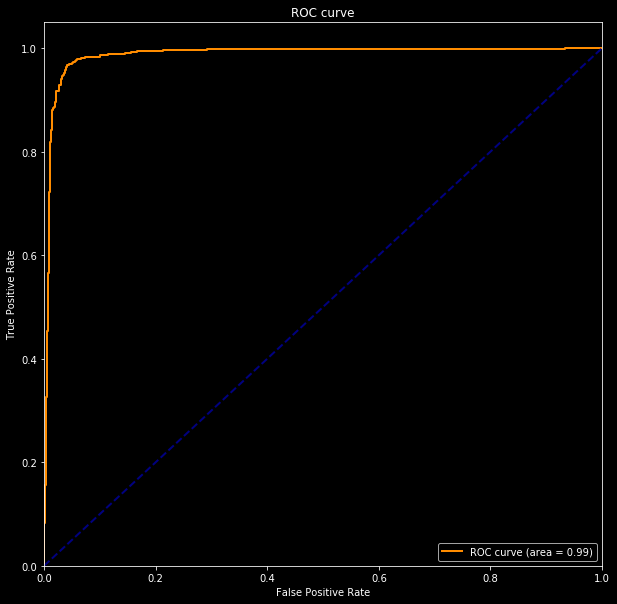

In [93]:
# hmm, nice.  
tpr, fpr, threshold, roc_auc_ = make_roc_curves_array(true_vals=test_y, scores_vals=bayes_preds_proba[:,1])

In [94]:
df_test = pd.DataFrame(test_X)

In [95]:
df_test['y_true'] = test_y

In [96]:
df_test['xgb_bayes_proba_0'] = bayes_preds_proba[:,0]
df_test['xgb_bayes_proba_1'] = bayes_preds_proba[:,1]

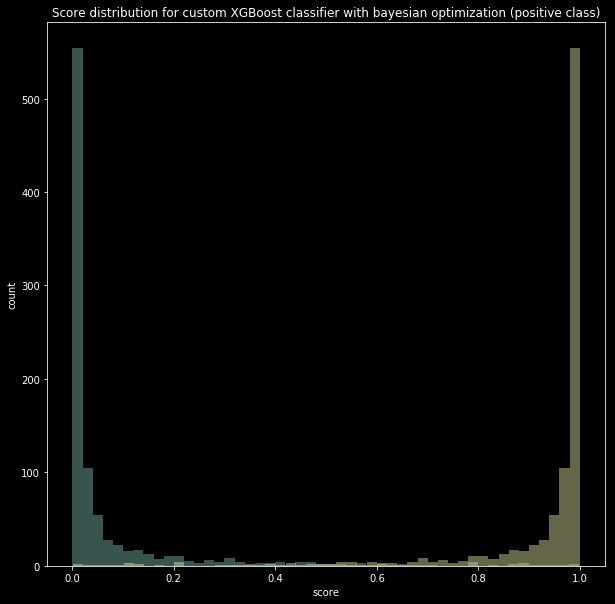

In [97]:
make_score_distribution(df=df_test, 
                        proba_cols=['xgb_bayes_proba_0', 'xgb_bayes_proba_1'], 
                        true_col='y_true', 
                        true_label=1, 
                        title='Score distribution for custom XGBoost classifier with bayesian optimization (positive class)')

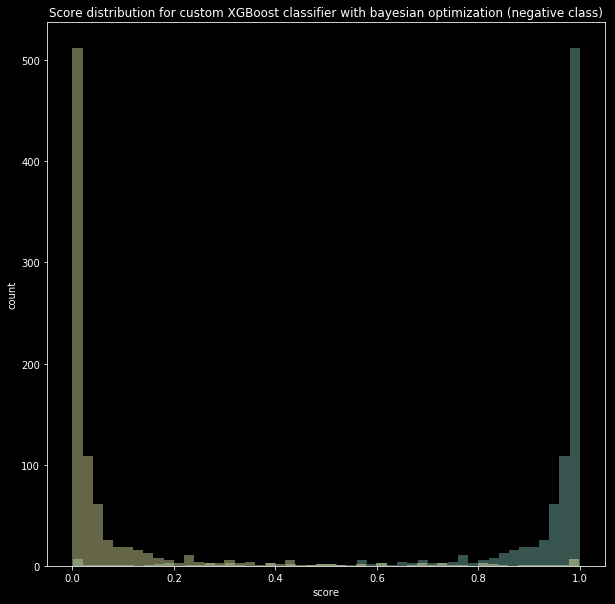

In [98]:
make_score_distribution(df=df_test, 
                        proba_cols=['xgb_bayes_proba_0', 'xgb_bayes_proba_1'], 
                        true_col='y_true', 
                        true_label=0, 
                        title='Score distribution for custom XGBoost classifier with bayesian optimization (negative class)')

In [99]:
# Try out the explainer function.  
explainer_shap, df_test_transformed = final_model_bayes.explain_shap(df_test.drop(['y_true', 'xgb_bayes_proba_0', 'xgb_bayes_proba_1'], axis=1))

In [100]:
df_test_transformed.head(3)

0         1         2         3         4         5         6   \
0 -0.282062  6.810863 -1.022980  0.023171 -7.662132 -4.086002  0.168960   
1 -0.114580  1.023059 -1.916631  1.211340  0.101868  1.979461 -2.250428   
2 -0.441956 -2.906158 -1.337548 -1.096948 -1.525806  4.918048 -0.970535   

         7         8         9          10         12        13         14  \
0 -1.289264 -3.928157  0.932619  -4.980928   3.509051  4.783022 -23.230503   
1 -0.240519  1.596768 -7.074036   2.371979  12.095352  6.985537  18.615904   
2 -0.861066 -3.235347 -1.332945  23.678747  -8.791630 -0.325422   5.049755   

         16         17        18        19         20        21        22  \
0  2.681817 -17.227381  1.032231 -1.820705  -4.592295 -1.659842  4.601570   
1 -1.022717  14.930343  0.235893 -2.667262 -13.074192 -1.206860  3.051502   
2  0.646907   0.473551  6.211017 -1.750226   2.554601 -3.986020  0.874848   

         24        25        27        28        29        31        33  \
0 -3.452121 -6.787809 -0.537065  4.022821 -4.333528 -4.094465 -4.113287   
1 -2.060325 -3.875699 -0.326408  9.099562  0.662743  1.575959 -0.639178   
2 -0.526825 -4.248507 -1.092752  4.690580 -4.261991  0.485191  2.295046   

          34        35         36        37        38        39        40  \
0  19.116912  0.169550  -5.869602 -2.400448  3.444085  6.451739 -0.148708   
1  11.030801  0.011996 -15.923867  2.970953 -2.218608  3.126656 -0.900328   
2  -7.161773  0.510741   5.512968 -4.842056  3.126352  0.679398  0.282659   

         41        42        43        44        45        46        47  \
0 -1.578393  3.460285 -1.494905  6.634149 -7.319251  0.306361 -1.158469   
1 -1.664403 -1.554446  3.446739 -1.736716  1.977584 -3.283606  2.234797   
2 -6.635972 -2.473376  0.404244 -1.579396  2.918672  3.410451  0.416070   

         48        49  
0  1.075858  5.694861  
1 -5.193317  3.765397  
2 -3.107844  0.763074

In [104]:
df_test_transformed.shape

(1800, 44)

In [105]:
# Yep, that did work...

In [107]:
shap_values = explainer_shap.shap_values(df_test_transformed.values)

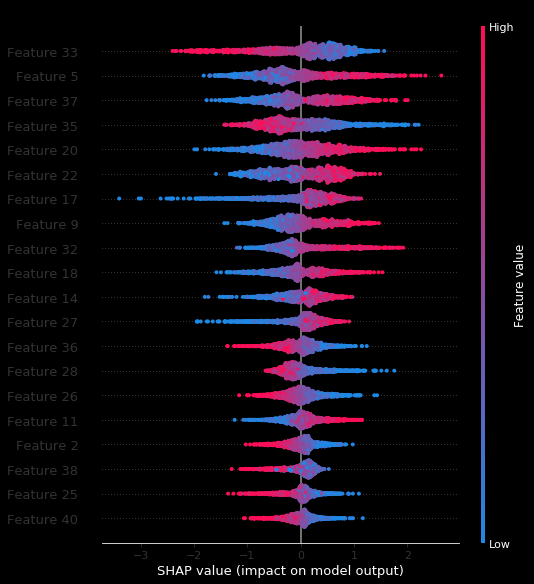

In [108]:
shap.summary_plot(shap_values, df_test_transformed.values)

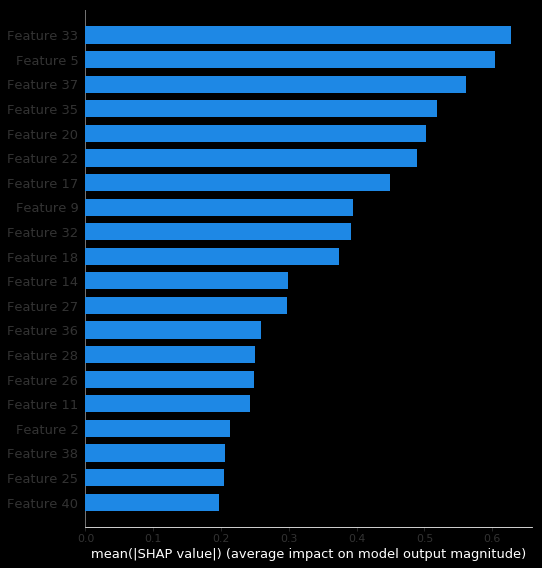

In [109]:
shap.summary_plot(shap_values, df_test_transformed.values, plot_type="bar")

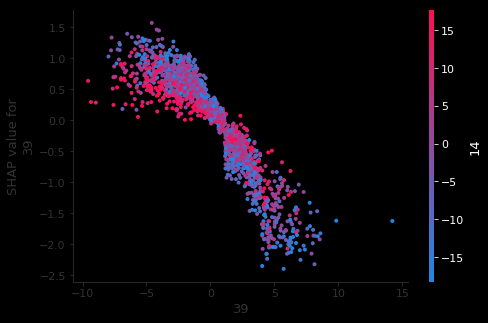

In [110]:
shap.dependence_plot(33, shap_values, df_test_transformed)

In [ ]:
# Nice so this works!  Let's give it a go!  

In [40]:
# Shap for explainability

In [41]:
transformed_test_X = final_model_bayes.feature_selector.transform(test_X)

In [45]:
explainer_shap = shap.TreeExplainer(final_model_bayes.classifier)

In [46]:
shap_values = explainer_shap.shap_values(transformed_test_X)

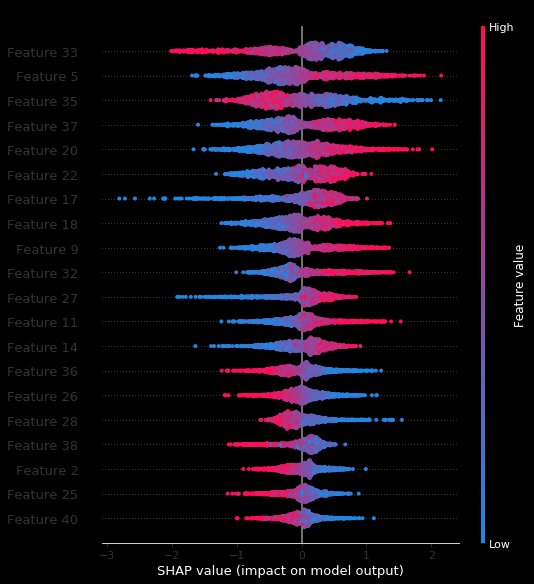

In [47]:
shap.summary_plot(shap_values, transformed_test_X)

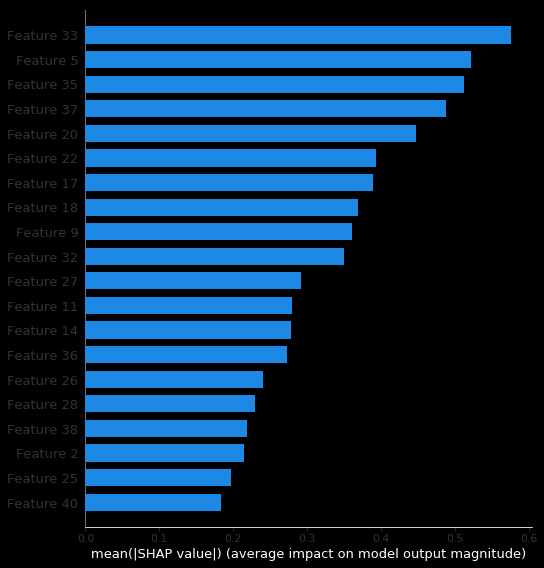

In [50]:
shap.summary_plot(shap_values, transformed_test_X, plot_type="bar")

In [48]:
shap.force_plot(explainer_shap.expected_value, shap_values[0], transformed_test_X[0])

In [49]:
df_test_transformed = pd.DataFrame(transformed_test_X)

In [51]:
df_test_transformed.head()

0         1         2         3         4         5         6   \
0 -0.282062  6.810863 -1.022980  0.023171 -7.662132 -4.086002  0.168960   
1 -0.114580  1.023059 -1.916631  1.211340  0.101868  1.979461 -2.250428   
2 -0.441956 -2.906158 -1.337548 -1.096948 -1.525806  4.918048 -0.970535   
3  0.409234 -1.073878  0.514389  0.197720 -1.887560 -2.862815 -3.573917   
4  0.390540 -2.705167 -1.128012 -1.909968 -3.520291  4.162462  4.789295   

         7         8         9          10         11        12         13  \
0 -1.289264 -3.928157  0.932619  -4.980928   3.509051  4.783022 -23.230503   
1 -0.240519  1.596768 -7.074036   2.371979  12.095352  6.985537  18.615904   
2 -0.861066 -3.235347 -1.332945  23.678747  -8.791630 -0.325422   5.049755   
3 -0.348710  5.444937  4.006060   5.784612   7.034169  3.206841  -0.604120   
4 -0.653314  3.944622  1.984026   7.133498   3.434621  1.814560 -12.022212   

         14         15        16        17         18        19        20  \
0  2.681817 -17.227381  1.032231 -1.820705  -4.592295 -1.659842  4.601570   
1 -1.022717  14.930343  0.235893 -2.667262 -13.074192 -1.206860  3.051502   
2  0.646907   0.473551  6.211017 -1.750226   2.554601 -3.986020  0.874848   
3  3.172103  -5.091992  1.858888  0.263584 -11.339390 -1.723873 -1.657178   
4 -0.395451  -7.683974 -0.337102  4.456782  -1.379592 -0.447398 -1.689432   

         21        22        23        24        25        26        27  \
0 -3.452121 -6.787809 -0.537065  4.022821 -4.333528 -4.094465 -4.113287   
1 -2.060325 -3.875699 -0.326408  9.099562  0.662743  1.575959 -0.639178   
2 -0.526825 -4.248507 -1.092752  4.690580 -4.261991  0.485191  2.295046   
3  8.018532  3.513687  0.280912  0.572621 -0.082012  0.289237  2.192533   
4 -0.677921  9.670471 -0.718905 -0.027524 -2.408618  0.500482  1.397349   

          28        29         30        31        32        33        34  \
0  19.116912  0.169550  -5.869602 -2.400448  3.444085  6.451739 -0.148708   
1  11.030801  0.011996 -15.923867  2.970953 -2.218608  3.126656 -0.900328   
2  -7.161773  0.510741   5.512968 -4.842056  3.126352  0.679398  0.282659   
3   1.616401 -0.005707  -0.760667 -0.938773 -1.920932  0.147089  0.084594   
4 -16.534112  0.002460  -3.428181  1.658856 -4.870379 -1.238635  1.542296   

         35        36        37        38        39        40        41  \
0 -1.578393  3.460285 -1.494905  6.634149 -7.319251  0.306361 -1.158469   
1 -1.664403 -1.554446  3.446739 -1.736716  1.977584 -3.283606  2.234797   
2 -6.635972 -2.473376  0.404244 -1.579396  2.918672  3.410451  0.416070   
3 -4.688370 -2.298581  1.165376  1.903811 -2.171587  0.158632 -1.041164   
4 -2.855283  3.741994  0.768497 -0.553712 -4.228656 -2.472315  0.071789   

          42        43  
0   1.075858  5.694861  
1  -5.193317  3.765397  
2  -3.107844  0.763074  
3  10.886984  0.942212  
4  18.613518  1.068773

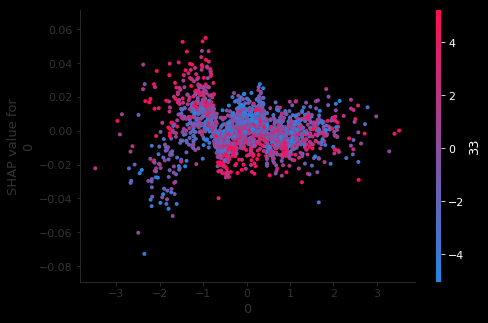

In [52]:
shap.dependence_plot(0, shap_values, df_test_transformed)

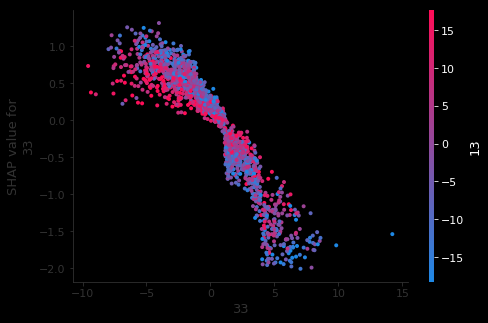

In [53]:
shap.dependence_plot(33, shap_values, df_test_transformed)

In [54]:
shap.force_plot(explainer_shap.expected_value, shap_values, df_test_transformed)

In [55]:
# Ok so some of these visualization won't work because of the weird way jupyter lab interacts with javascript...

In [57]:
# Let's try lime on this thing...This is tabular data, so this should work...

In [58]:
df_train_transformed = pd.DataFrame(final_model_bayes.feature_selector.transform(train_X))

In [59]:
explainer_lime = lime.lime_tabular.LimeTabularExplainer(df_train_transformed.values, class_names=[0, 1], feature_names=df_train_transformed.columns)

AttributeError: 'module' object has no attribute 'lime_tabular'

In [61]:
df_test.head()

0         1         2         3         4         5         6  \
0 -0.282062  6.810863 -1.022980  0.023171 -7.662132 -4.086002  0.168960   
1 -0.114580  1.023059 -1.916631  1.211340  0.101868  1.979461 -2.250428   
2 -0.441956 -2.906158 -1.337548 -1.096948 -1.525806  4.918048 -0.970535   
3  0.409234 -1.073878  0.514389  0.197720 -1.887560 -2.862815 -3.573917   
4  0.390540 -2.705167 -1.128012 -1.909968 -3.520291  4.162462  4.789295   

          7         8         9         10         11         12        13  \
0 -1.289264 -3.928157  0.932619  -4.980928  27.672940   3.509051  4.783022   
1 -0.240519  1.596768 -7.074036   2.371979   4.517654  12.095352  6.985537   
2 -0.861066 -3.235347 -1.332945  23.678747  -1.949164  -8.791630 -0.325422   
3 -0.348710  5.444937  4.006060   5.784612  23.440000   7.034169  3.206841   
4 -0.653314  3.944622  1.984026   7.133498  -1.791673   3.434621  1.814560   

          14        15        16         17        18        19         20  \
0 -23.230503 -0.837203  2.681817 -17.227381  1.032231 -1.820705  -4.592295   
1  18.615904 -1.724236 -1.022717  14.930343  0.235893 -2.667262 -13.074192   
2   5.049755  1.060988  0.646907   0.473551  6.211017 -1.750226   2.554601   
3  -0.604120 -0.474770  3.172103  -5.091992  1.858888  0.263584 -11.339390   
4 -12.022212  0.658333 -0.395451  -7.683974 -0.337102  4.456782  -1.379592   

         21        22        23        24        25        26        27  \
0 -1.659842  4.601570  0.075498 -3.452121 -6.787809 -3.863113 -0.537065   
1 -1.206860  3.051502  4.076716 -2.060325 -3.875699  0.491937 -0.326408   
2 -3.986020  0.874848 -1.894190 -0.526825 -4.248507 -2.755120 -1.092752   
3 -1.723873 -1.657178  1.354446  8.018532  3.513687 -6.310252  0.280912   
4 -0.447398 -1.689432  2.356936 -0.677921  9.670471  0.976791 -0.718905   

         28        29        30        31        32        33         34  \
0  4.022821 -4.333528 -2.243308 -4.094465 -0.832266 -4.113287  19.116912   
1  9.099562  0.662743 -0.758201  1.575959 -0.492137 -0.639178  11.030801   
2  4.690580 -4.261991  0.698752  0.485191 -0.742397  2.295046  -7.161773   
3  0.572621 -0.082012 -0.181108  0.289237 -0.658515  2.192533   1.616401   
4 -0.027524 -2.408618 -0.792061  0.500482 -0.885223  1.397349 -16.534112   

         35         36        37        38        39        40        41  \
0  0.169550  -5.869602 -2.400448  3.444085  6.451739 -0.148708 -1.578393   
1  0.011996 -15.923867  2.970953 -2.218608  3.126656 -0.900328 -1.664403   
2  0.510741   5.512968 -4.842056  3.126352  0.679398  0.282659 -6.635972   
3 -0.005707  -0.760667 -0.938773 -1.920932  0.147089  0.084594 -4.688370   
4  0.002460  -3.428181  1.658856 -4.870379 -1.238635  1.542296 -2.855283   

         42        43        44        45        46        47         48  \
0  3.460285 -1.494905  6.634149 -7.319251  0.306361 -1.158469   1.075858   
1 -1.554446  3.446739 -1.736716  1.977584 -3.283606  2.234797  -5.193317   
2 -2.473376  0.404244 -1.579396  2.918672  3.410451  0.416070  -3.107844   
3 -2.298581  1.165376  1.903811 -2.171587  0.158632 -1.041164  10.886984   
4  3.741994  0.768497 -0.553712 -4.228656 -2.472315  0.071789  18.613518   

         49  y_true  xgb_bayes_proba_0  xgb_bayes_proba_1  
0  5.694861       0           0.995248           0.004752  
1  3.765397       1           0.162837           0.837163  
2  0.763074       1           0.005560           0.994440  
3  0.942212       1           0.053239           0.946761  
4  1.068773       1           0.007863           0.992137

In [65]:
df_wtf = final_model_bayes.feature_selector.transform(df_test.drop(['y_true', 'xgb_bayes_proba_0', 'xgb_bayes_proba_1'], axis=1))

In [68]:
df_wtf = df_test[df_test.columns[final_model_bayes.feature_selector.get_support(indices=True)]]

In [69]:
df_wtf.head()

0         1         2         3         4         5         6   \
0 -0.282062  6.810863 -1.022980  0.023171 -7.662132 -4.086002  0.168960   
1 -0.114580  1.023059 -1.916631  1.211340  0.101868  1.979461 -2.250428   
2 -0.441956 -2.906158 -1.337548 -1.096948 -1.525806  4.918048 -0.970535   
3  0.409234 -1.073878  0.514389  0.197720 -1.887560 -2.862815 -3.573917   
4  0.390540 -2.705167 -1.128012 -1.909968 -3.520291  4.162462  4.789295   

         7         8         9          10         12        13         14  \
0 -1.289264 -3.928157  0.932619  -4.980928   3.509051  4.783022 -23.230503   
1 -0.240519  1.596768 -7.074036   2.371979  12.095352  6.985537  18.615904   
2 -0.861066 -3.235347 -1.332945  23.678747  -8.791630 -0.325422   5.049755   
3 -0.348710  5.444937  4.006060   5.784612   7.034169  3.206841  -0.604120   
4 -0.653314  3.944622  1.984026   7.133498   3.434621  1.814560 -12.022212   

         16         17        18        19         20        21        22  \
0  2.681817 -17.227381  1.032231 -1.820705  -4.592295 -1.659842  4.601570   
1 -1.022717  14.930343  0.235893 -2.667262 -13.074192 -1.206860  3.051502   
2  0.646907   0.473551  6.211017 -1.750226   2.554601 -3.986020  0.874848   
3  3.172103  -5.091992  1.858888  0.263584 -11.339390 -1.723873 -1.657178   
4 -0.395451  -7.683974 -0.337102  4.456782  -1.379592 -0.447398 -1.689432   

         24        25        27        28        29        31        33  \
0 -3.452121 -6.787809 -0.537065  4.022821 -4.333528 -4.094465 -4.113287   
1 -2.060325 -3.875699 -0.326408  9.099562  0.662743  1.575959 -0.639178   
2 -0.526825 -4.248507 -1.092752  4.690580 -4.261991  0.485191  2.295046   
3  8.018532  3.513687  0.280912  0.572621 -0.082012  0.289237  2.192533   
4 -0.677921  9.670471 -0.718905 -0.027524 -2.408618  0.500482  1.397349   

          34        35         36        37        38        39        40  \
0  19.116912  0.169550  -5.869602 -2.400448  3.444085  6.451739 -0.148708   
1  11.030801  0.011996 -15.923867  2.970953 -2.218608  3.126656 -0.900328   
2  -7.161773  0.510741   5.512968 -4.842056  3.126352  0.679398  0.282659   
3   1.616401 -0.005707  -0.760667 -0.938773 -1.920932  0.147089  0.084594   
4 -16.534112  0.002460  -3.428181  1.658856 -4.870379 -1.238635  1.542296   

         41        42        43        44        45        46        47  \
0 -1.578393  3.460285 -1.494905  6.634149 -7.319251  0.306361 -1.158469   
1 -1.664403 -1.554446  3.446739 -1.736716  1.977584 -3.283606  2.234797   
2 -6.635972 -2.473376  0.404244 -1.579396  2.918672  3.410451  0.416070   
3 -4.688370 -2.298581  1.165376  1.903811 -2.171587  0.158632 -1.041164   
4 -2.855283  3.741994  0.768497 -0.553712 -4.228656 -2.472315  0.071789   

          48        49  
0   1.075858  5.694861  
1  -5.193317  3.765397  
2  -3.107844  0.763074  
3  10.886984  0.942212  
4  18.613518  1.068773

In [70]:
df_wtf.shape

(1800, 44)

In [111]:
# Ok yeah, that works...we can use this inside the class to get the shap function cleaned up.  
int(44.1)

44

In [112]:
int(44.8)

44